<a href="https://colab.research.google.com/github/manasdesai/AgriCPS_IISc/blob/main/Copy_of_With_improved_RRT_and_cost_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from os import path
from numpy import sin,cos
import math
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import random
import open3d as o3d
import copy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import networkx as nx
from sympy import symbols,Eq,solve

show_animation=True
operating_height = 2.0 # Forest_Refined.ply
x_lim, y_lim = [0.0, 0.0], [0.0, 0.0] # [min, max]

In [ ]:
def slice(height, width, pcd):
    sliced_pts = []
    for point in pcd:
        if (point[2]<=height+width and point[2]>=height-width):
            sliced_pts.append([point[0], point[1], point[2]])
    print("Sampled points from slicing: ", len(sliced_pts))
    return sliced_pts

In [ ]:
def plot_grid(points):
    x_pts = [point[0] for point in points]
    y_pts = [point[1] for point in points]
    plt.figure()
    plt.scatter(x_pts, y_pts, color='green',s=0.5)

In [ ]:
def clustering(data):
    points = np.array(data)
    db = DBSCAN(eps=0.45, min_samples=10).fit(points)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("number of estimated clusters : %d" % n_clusters_)
    unique_labels = set(labels)
    colors = [plt.cm.rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise ##IGNORED.
            col = "None"
        else:
          class_member_mask = labels == k

          xy = points[class_member_mask & core_samples_mask]
          plt.plot(
              xy[:, 0],
              xy[:, 1],
              "o",
              markerfacecolor=tuple(col),
              markeredgecolor="k",
              markersize=2.5,
              linewidth=0.25,
              label = "_nolegend_"
          )
          mean_cluster = np.mean(xy, axis=0)
          plt.text(mean_cluster[0], mean_cluster[1], str(k+1), fontsize=7, bbox=dict(boxstyle="round",
                   ec="k",
                   fc="w",
                   ))
    plt.title("Estimated number of clusters: %d" % n_clusters_)
    return db

In [ ]:
def project_hull(points, distance):
  projected_pts = []
  center_cluster = np.array(points).mean(axis=0)
  plt.scatter(center_cluster[0], center_cluster[1], color='Black', marker="*")
  myatan = lambda x,y: math.atan2(y,x)
  angle_pts = []
  for i, pt in enumerate(points):
    if(i-1)<0:
      angle_pt = myatan(points[i+1][0]-points[-1][0], points[i+1][1]-points[-1][1])
    elif(i+1>=len(points)):
      angle_pt = myatan(points[0][0]-points[-1][0], points[0][1]-points[-1][1])
    else:
      angle_pt = myatan(points[i+1][0]-points[i-1][0], points[i+1][1]-points[i-1][1])
    angle_pt = angle_pt*180.0/np.pi + 90#Converting into  degrees
    angle_pts.append([pt[0], pt[1], angle_pt])
  for pt in angle_pts:
    new_pt = [0.0, 0.0, 0.0]
    new_pt[0] = pt[0] + distance*(np.cos(pt[2]*np.pi/180))
    new_pt[1] = pt[1] + distance*(np.sin(pt[2]*np.pi/180))
    new_pt[2] = pt[2]*np.pi/180 + np.pi
    projected_pts.append(new_pt)
  return np.array(projected_pts)

In [ ]:
def get_labeled_cluster_dict( pcd_load, operating_height ):

    # Based on the POV, aligning and centering pointcloud
    R = pcd_load.get_rotation_matrix_from_xyz((-np.pi, 0, 0))
    pcd_load_centered = copy.deepcopy(pcd_load).translate((0, 0, 0), relative=False)
    pcd_load_rotated = pcd_load_centered.rotate(R, center=np.array([0,0,0]))
    height_correction = (np.asarray(pcd_load_rotated.points)[:, 2]).min()
    pcd_load_transformed = copy.deepcopy(pcd_load_rotated).translate((0, 0, -height_correction), relative=False)

    # Centered and Aligned Pointcloud
    xyz_load = np.asarray(pcd_load_transformed.points)
    # print('PointCloud loaded with', len(xyz_load), 'points')

    # Respective points
    x_pcd = xyz_load[:, 0]
    y_pcd = xyz_load[:, 1]
    z_pcd = xyz_load[:, 2]
    x_lim = [x_pcd.min(), x_pcd.max()]
    y_lim = [y_pcd.min(), y_pcd.max()]
    # print("Maximum Height of Biomass Recorded", round(z_pcd.max() - z_pcd.min(), 2), "meters")

    ### Point Cloud Loaded ###
    thickness = 0.05 # Farm_meshed
    hull_points= []
    hull_areas= []

    # Slicing
    sliced_pts = slice(operating_height, thickness, xyz_load)

    # Clustering using DBSCAN
    cluster = clustering(sliced_pts)
    sliced_pts = np.array(sliced_pts)
    # print(np.shape(sliced_pts))


    #plt.scatter(sliced_pts[:,0],sliced_pts[:,1])
    #plt.show()

    clus = {}

    n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
    for k in range(n_clusters_):
        clus["a" + str(k)] = np.array([0,0,0])


    for i in range(len(sliced_pts)):
        for k in range(n_clusters_):
            if cluster.labels_[i] == k:
                clus["a" + str(k)] = np.vstack([clus["a" + str(k)], sliced_pts[i]])

    for i in range(n_clusters_):
        clus["a" + str(i)] = (clus["a" + str(i)])[1:len(clus["a" + str(i)]),:]

    return clus


In [ ]:
def generate_boundary(clus):
    # Description:  Calcualtes the boundary points on the cluster points that form the convex hull
    # Input:
    #       clus:   A dictionary with the keys 'a0','a1','a2',.. and the values are numpy arrays that correspond to the (x,y)  #               coordinates of each point in the cluster
    # Returns:
    #       pp:     A dictionary with the keys 'a0','a1','a2',.. and the values are numpy arrays that correspond to the (x,y)
    #               coordinates of the boundary points of the convex hull of the cluster points
    #               dim: (N,(n,2)), N is the number of clusters, n is the number of boundary points in each cluster
    pp = {}
    for i in range(len(clus)):
        points = (clus["a" + str(i)])[:,0:2]
        hull = ConvexHull(points)
        boundary_pts = points[hull.vertices,0:2]
        pp["a" + str(i)] = np.array(boundary_pts)

    return pp

def return_boundary_pts(clus):
    boundary_pts=[]
    for i in range(len(clus)):
        points = (clus["a" + str(i)])[:,0:2]
        hull = ConvexHull(points)
        boundary_pts.extend(points[hull.vertices,0:2])

    return boundary_pts


def generate_A_B(XY,pad):
    # Description:  Calcualtes the matrices A and B for the convex hull Ax <= B for a single cluster
    # Input:
    #       XY:     numpy array of boundary points of the convex hull
    #       pad:    The padding to be added to each generated convex hull
    # Returns:
    #       d:     A dictionary with the keys 'A','B' with values that correspond to A and B matrices of the convex hull

    x = XY[:,0]
    x = np.append(x,x[0])
    y = XY[:,1]
    y = np.append(y,y[0])

    N = len(x)      # number of elements in the xy array

    # finding the center point of the cluster
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    A = np.zeros((N-1, 2))
    B = np.zeros((N-1, 1))
    # print(x)
    # finding the equation of the lines

    for i in range(N-1):
        # print("x diff ",x[i] - x[i+1])
        m = (y[i+1] - y[i] + 1e-25)/(x[i+1] - x[i] + 1e-25)
        # if x[i+1] - x[i] == 0:
        #     print("i: ",i)
        #     print("dummy")
        #     print("m: ",m)
        if m >= 999:
            m = 999
        elif m <= -999:
            m = -999

        c = y[i] - m*x[i]

        if m*x_mean - y_mean + c <= 0:
            A[i,:] = [m,-1]
            B[i,0] = -c
        else:
            A[i,:] = [-m,1]
            B[i,0] = c

    d = pad
    for i in range(N-1):
        if A[i,1] > 0:
            if y_mean - A[i,0]*x_mean + B[i,0] > 0 :
                B[i,0] += np.sqrt(1 + A[i,0]**2)*d
            else:
                B[i,0] -= np.sqrt(1 + A[i,0]**2)*d

        else:
            if y_mean - A[i,0]*x_mean + B[i,0] > 0:
                B[i,0] += np.sqrt(1 + A[i,0]**2)*d
            else:
                B[i,0] -= np.sqrt(1 + A[i,0]**2)*d

    d = {}
    d["A"] = A
    d["B"] = B

    return d

def return_boundarypts_dict(clus):
  pp=generate_boundary(clus)
  return pp

def generate_A_b_padding(clus, pad):
    # Description:  Calcualtes the matrices A and B for the convex hull Ax <= B for all the clusters
    # Input:
    #       clus:   A dictionary with the keys 'a0','a1','a2',.. and the values are numpy arrays that correspond to the (x,y)  #               coordinates of each point in the cluster
    #       pad:    The padding to be added to each generated convex hull
    # Returns:
    #       dd:     A dictionary with the keys 'A0','B0','A1','B1',.. that correspond to the Ai,Bi of the ith cluster
    dd = {}
    pp = generate_boundary(clus)
    for i in range(len(clus)):
        d = generate_A_B(pp["a" + str(i)], pad)
        dd["A" + str(i)] = d["A"]
        dd["B" + str(i)] = d["B"]
    return dd

In [ ]:
#RRT planning
class Node:
  def __init__(self,x,y):
    self.x,self.y=x,y
    self.path_x=[]
    self.path_y=[]
    self.value=1
    self.Parent=None
    self.cluster=None

  def __eq__(self, o: object) -> bool:
    return self.x == o.x and self.y == o.y


class xyz:
  def __init__(self,start,goal,obstacle_list,boundary_pts,sliced_pts,rasterized_map,alpha,beta,steplength,DT,threshold=1,max_iteration=50000):
    self.start=Node(start[0],start[1])
    self.goal=Node(goal[0],goal[1])
    self.obstacle_list=obstacle_list
    self.boundary_pts=boundary_pts
    self.sliced_pts=sliced_pts
    self.rasterized_map=rasterized_map
    self.alpha=alpha
    self.beta=beta

    self.steplength=steplength
    self.DT=DT
    self.threshold=threshold
    self.max_iteration=max_iteration
    self.edge_list=[]
    self.vertice_list=[]
    self.graph={}
    self.vertices_no=0
    self.ps_values=[]
    self.delta_values=[]
    self.percentages_goal=[]

  def planning(self):
    self.node_list=[self.start]
    count=0
    iterations=[]
    for i in range(self.max_iteration):
      count+=1
      iterations.append(count)
      random_nodes=self.get_random_nodes(self.node_list[-1],self.obstacle_list,self.steplength)
      if not random_nodes:

        continue
      #[self.draw_graph(random_node) for random_node in random

      for index,item in enumerate(random_nodes):
        for val in self.boundary_pts.values():
          if self.check_collision_of_path(item,self.node_list[-1],val)==False:
            random_nodes.pop(index)
            break

      if not random_nodes:
        continue

      self.add_vertex((self.node_list[-1].x,self.node_list[-1].y))
      for node in random_nodes:
        self.plot_decisiontree(node)

      nearest_node=self.get_mincost_node(random_nodes,self.goal)
      #if self.check_collision_of_path(nearest_node,self.node_list[-1],self.boundary_pts):
      nearest_node.Parent=self.node_list[-1]
      self.node_list.append(nearest_node)
        #print(nearest_node)
      self.draw_graph()
      if self.cal_distance_togoal(self.node_list[-1])<=self.threshold:
        self.plot_decisiontree()
          #self.goal.Parent=self.node_list[-1]
          # self.node_list.append(self.goal)
        self.draw_graph()
        self.path_pts=self.generate_final_course(self.node_list[-1])
        #path_without_start=self.path_pts[1::]
        print("the initial path before rewiring is ",self.path_pts)
        h=[]
        for path in self.path_pts:
          h.append(path)
        rewired_path=self.rewire(h,self.graph)
        #self.plot_decisiontree()
        #Plotting ps and delta vs No of iterations
        plt.plot([iteration for iteration in iterations],[ps for ps in self.ps_values],'-r',label='ps')
        plt.plot([iteration for iteration in iterations],[ps for ps in self.ps_values],'bo',markersize=1)
        plt.plot([iteration for iteration in iterations],[delta for delta in self.delta_values],'tab:orange',label='delta')
        plt.plot([iteration for iteration in iterations],[delta for delta in self.delta_values],'co',markersize=1)
        title='DT is {}'
        plt.title(title.format(self.DT),fontsize=15)
        plt.xlabel('No of iterations',fontsize=15)
        plt.legend(loc="lower right")
        # plt.figure()
        # plt.plot([iteration ],[goalpercent for goalpercent in self.percentages_goal],'m',)
        plt.show()
        print("Mean of ps values is ",np.mean(self.ps_values))
        return self.path_pts,rewired_path,iterations,self.percentages_goal



      continue

    return None

  def calculate_cost(self,vertex,parent,child):

    v_uavx_ini=(parent.x-vertex.x) #Directional vector from the parent to the vertex
    v_uavy_ini=(parent.y-vertex.y)
    theta=1.57-(np.radians(math.atan2(v_uavy_ini,v_uavx_ini))) #Angle between the wind vector and v_uav
    v_assist_ini=4*math.cos(theta) #Component along v_uav
    v_drag_ini=4*math.sin(theta)   #Component perpendicular to v_uav
    dist_cost=math.sqrt(((parent.x - vertex.x)**2) + (parent.y - vertex.y)**2)+math.sqrt(((child.x-parent.x)**2)+(child.y-parent.y)**2)
    v_uavx_fin=(child.x-parent.x) #Directional vector from random node to the goal point
    v_uavy_fin=(child.y-parent.y)
    thetaa=1.57-(np.radians(math.atan2(v_uavy_fin,v_uavx_fin))) #Angle between the wind vector and v_uav
    v_assist_fin=4*math.cos(thetaa) #Component along v_uav
    v_drag_fin=4*math.sin(thetaa)   #Component perpendicular to v_uav
      #alpha=0.9
      #beta=0.1
    wind_cost=(abs(v_drag_ini)/(abs(v_assist_ini)**(v_assist_ini/abs(v_assist_ini))))+((abs(v_drag_fin)/(abs(v_assist_fin)**(v_assist_fin/abs(v_assist_fin)))))
    Totalcost=(self.alpha*dist_cost)+(self.beta*wind_cost)
    return Totalcost



  def get_rewired_parent(self,vertex,edges,child_node):
    costs=[]
    for index,edge in enumerate(edges):
      for value in self.boundary_pts.values():
        if self.check_collision_of_path(Node(edge[0],edge[1]),child_node,value)==False or self.check_collision_of_path(Node(vertex[0],vertex[1]),Node(edge[0],edge[1]),value)==False:
          print("edge is poped out of the edges")
          edges.pop(index)
          break

    for edge in edges:
      costs.append(self.calculate_cost(Node(vertex[0],vertex[1]),Node(edge[0],edge[1]),child_node))
    print("costs are ",costs)
    min_index=costs.index(min(costs))
    if min(costs)<self.calculate_cost(Node(vertex[0],vertex[1]),child_node.Parent,child_node):

      print("returning rewired parent")
      min_node_edge=Node(edges[min_index][0],edges[min_index][1])
      return min_node_edge
    else:
      print("returning original parent")
      return child_node.Parent


  def rewire(self,path,tree):
    i=0
    #print("the initial path is ",path)
    for vertex,edges in tree.items():
      # if vertex[0]==self.goal.Parent.x and vertex[1]==self.goal.Parent.y:
      #   return path
      #print("path[i+2] is ",path[i+2])
      if path[i+2]==self.goal:
        print("the rewired path is ",path)
        return path
      rewired_node=self.get_rewired_parent(vertex,edges,path[i+2])
      if rewired_node in self.path_pts:
        print("Both the rewired node and the path node are the same")
      else:
        print("rewired node and the path node are different")
      path[i+1]=rewired_node
      if path[i+1] in self.path_pts:
        print("Parent node is not rewired")

      path[i+2].Parent=rewired_node
      path[i+1].Parent=path[i]
      i+=1

  #Add a vertex to the dictionary
  def add_vertex(self,v):

    # if v in self.graph:
    #   print("Vertex ", v, " already exists.")
    # else:
    self.vertices_no = self.vertices_no + 1
    self.graph[v] = []

  def add_edge(self,v1, v2):

    # Check if vertex v1 is a valid vertex
    # if v1 not in self.graph:
    #   print("Vertex ", v1, " does not exist.")
    # # Check if vertex v2 is a valid vertex
    # elif v2 not in self.graph:
    #   print("Vertex ", v2, " does not exist.")
    # else:
      # Since this code is not restricted to a directed or
      # an undirected graph, an edge between v1 v2 does not
      # imply that an edge exists between v2 and v1
      #temp = [v2]
    self.graph[v1].append(v2)

  def print_graph(self):

    for vertex in self.graph:
      #for edges in self.graph[vertex]:
      print(vertex, " -> ", self.graph[vertex])

  def plot_decisiontree(self,rnd_node=None):
    global G
    G = nx.DiGraph()
    #self.add_vertex((self.start.x,self.start.y))
    self.vertice_list.append((self.start.x,self.start.y))
    #self.labels[(self.start.x,self.start.y)]=(self.start.x,self.start.y)
    if rnd_node is not None:
      #print(rnd_node)
      G.add_node((rnd_node.x,rnd_node.y))
      G.add_edge((self.node_list[-1].x,self.node_list[-1].y),(rnd_node.x,rnd_node.y))
      #self.add_vertex((rnd_node.x,rnd_node.y))
      self.add_edge((self.node_list[-1].x,self.node_list[-1].y),(rnd_node.x,rnd_node.y))
      #print("gone in the loop")
      #self.labels[(rnd_node.x,rnd_node.y)]=(rnd_node.x,rnd_node.y)
      self.vertice_list.append((rnd_node.x,rnd_node.y))
      self.edge_list.append([(self.node_list[-1].x,self.node_list[-1].y),(rnd_node.x,rnd_node.y)])
      #print(self.edge_list)
    else:
      nodecolormap=[]
      edgecolormap=[]
      self.vertice_list.append((self.goal.x,self.goal.y))
      self.add_vertex((self.node_list[-1].x,self.node_list[-1].y))
      self.edge_list.append([(self.node_list[-1].x,self.node_list[-1].y),(self.goal.x,self.goal.y)])
      self.add_edge((self.node_list[-1].x,self.node_list[-1].y),(self.goal.x,self.goal.y))
      self.print_graph()
      #print(self.graph)
      #print(self.edge_list)
      G.add_nodes_from(self.vertice_list)
      G.add_edges_from(self.edge_list)
      for node in G:
        if node[0]==self.start.x and node[1]==self.start.y:
          nodecolormap.append('red')
        elif node[0]==self.goal.x and node[1]==self.goal.y:
          nodecolormap.append('black')
        else:
          nodecolormap.append('green')

      # for edge in self.edge_list:
      #   # print(edge[0])
      #   # print(edge[1])

      #   if edge[0] in self.path_pts and edge[1] in self.path_pts:
      #     edgecolormap.append('black')
      #   else:
      #     edgecolormap.append('blue')

      #self.labels[(self.goal.x,self.goal.y)]=(self.goal.x,self.goal.y)
      #pos=nx.spring_layout(G)
      #plt.figure(figsize=(20,20))
      #nx.draw_networkx(G,node_color=nodecolormap,edge_color=edgecolormap)

      #plt.show()
      print(G)

  def plot_grid(self,points):
    x_pts = [point[0] for point in points]
    y_pts = [point[1] for point in points]
    #plt.figure()
    plt.scatter(x_pts, y_pts, color='green',s=0.5)

  def cal_distance_and_angle(self,pt1,pt2):
    dx=pt2.x-pt1.x
    dy=pt2.y-pt1.y
    d=math.hypot(dx,dy)
    theta=math.atan2(dy,dx)
    return d,theta

  def get_gridsinside_circle(self,parentnode,r,gridnodes):
    gridsinside=[]
    for node in gridnodes:
      if self.cal_distance_and_angle(node,parentnode)[0]<=r:
        #print(self.cal_distance_and_angle(node,parentnode)[0])
        gridsinside.append(node)

    return gridsinside

  def steer(self,lastnode,goal,delta):


    d,theta=self.cal_distance_and_angle(lastnode,goal)
    # if d<=delta:
    #   delta=d
    rad=random.uniform(0.01,delta+0.01)
    #print("random radius for goal sampling is ",rad)
    h=lastnode.x+(rad*math.cos(theta))
    k=lastnode.y+(rad*math.sin(theta))
    new_node=Node(h,k)


    return new_node

  def check_all_equal(self,obstacle_grids):
    for i in range(len(obstacle_grids)-1):
      if obstacle_grids[i].cluster==obstacle_grids[i+1].cluster:
        continue
      else:
        return False

    return True

  def get_random_nodes(self,last_node,obstaclelist,delta_init,r=2):
    sampled_nodes=[]
    all_grids=self.get_gridsinside_circle(last_node,r,self.rasterized_map)
    obstacle_grids=[grid for grid in all_grids if grid.value==0]
    ps=len(obstacle_grids)/len(all_grids) #obstacle density ps
    self.ps_values.append(ps)
    #plt.Circle((last_node.x,last_node.y),r,fill=False)
    #plt.scatter([grid.x for grid in obstacle_grids],[grid.y for grid in obstacle_grids],s=2)
    #plt.show()
    #print(ps)
    if ps==0:
      print("Obstacle density is 0")
      delta=delta_init

    elif len(obstacle_grids)==1:
      delta=delta_init
      print("There is only one obstacle grid with delta {} and obstacle density {}".format(delta,ps))

    elif self.check_all_equal(obstacle_grids):
      delta=delta_init
      print("All the grids belong to the same cluster with delta {} and obstacle density {}".format(delta,ps))
    # elif [obstacle_grids[i].cluster==obstacle_grids[i+1].cluster for i in range(len(obstacle_grids)-1)]:
    #   delta=delta_init

    else:
      dis_list=[]
      for i in range(len(obstacle_grids)):
        for j in range(len(obstacle_grids)):
          if i==j:
            continue

          elif obstacle_grids[i].cluster==obstacle_grids[j].cluster:
            continue

          else:
            d,theta=self.cal_distance_and_angle(obstacle_grids[i],obstacle_grids[j])
            dis_list.append(d)
            #d,theta=self.cal_distance_and_angle(obstacle_grids[i],obstacle_grids[j])

      #print(f"length of dis_list is {len(dis_list)}")
      dmin=min(dis_list)
      #print(dmin)
      k1=0.7
      k2=0.3
      delta=((k1*math.tanh(dmin))+ k2)*delta_init
      #print(f"value of dmin inside else block is {dmin},delta is {delta} and obstacle density is {ps}")

    #print(f"delta outside else block is {delta}")
    self.delta_values.append(delta)
    #print(delta)
    goalsamplingcount=0
    Totalcount=0
    for i in range(50):
      Totalcount+=1
      theta=random.random()*math.pi*2
      h=(last_node.x)+(delta*cos(theta))
      k=(last_node.y)+(delta*sin(theta))
      cir_pt=Node(h,k)
      p=random.random() #uniform random variable p
      if ps<=self.DT:
        if p<=ps:
          cir_pt=self.steer(last_node,self.goal,2*delta)
          goalsamplingcount+=1


      else:
        if p>=ps:
          cir_pt=self.steer(last_node,self.goal,2*delta)
          goalsamplingcount+=1

      if self.check_collision(cir_pt,obstaclelist)==False:
        continue

      elif abs(cir_pt.x)>=10 or abs(cir_pt.y)>=10:
        print("The sampled point is outside the grid")
        continue

      elif self.cal_distance_togoal(cir_pt) <= self.threshold:
        sampled_nodes.append(cir_pt)
        break

      else:
        sampled_nodes.append(cir_pt)

    percentage_goal_sampling=(goalsamplingcount)/(Totalcount)
    self.percentages_goal.append(percentage_goal_sampling)

    return sampled_nodes

  def check_collision(self,node, obstacleList):

    if node is None:
      return False
    X=np.array([[node.x],[node.y]])

    for i in range(24):
      A=obstacleList["A"+str(i)]
      B=obstacleList["B"+str(i)]
      D=np.dot(A,X)
      c=np.subtract(D,B)
          #print(c)
      if max(c)<=0:
        return False #collision

    return True

  def return_bool_value(self,node1,node2,obstacles):
    for ox,oy,oz in obstacles:
      if (ox-node1.x)==0:
        E=np.array([node1.x-ox,node1.y-oy])
        F=np.array([node2.x-ox,node2.y-oy])
        if np.dot(E,F)<=0:
          return False #in collision
    return True #No collision

   #Given three collinear points p, q, r, the function checks if
# point q lies on line segment 'pr'
  def onSegment(self,p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False

  def orientation(self,p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise

    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/
    # for details of below formula.

    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):

        # Clockwise orientation
        return 1
    elif (val < 0):

        # Counterclockwise orientation
        return 2
    else:

        # Collinear orientation
        return 0

# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect.
  def doIntersect(self,p1,q1,p2,q2):

    # Find the 4 orientations required for
    # the general and special cases
    o1 = self.orientation(p1, q1, p2)
    o2 = self.orientation(p1, q1, q2)
    o3 = self.orientation(p2, q2, p1)
    o4 = self.orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True

    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and self.onSegment(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and self.onSegment(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and self.onSegment(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and self.onSegment(p2, q1, q2)):
        return True

    # If none of the cases
    return False

  def check_collision_of_path(self,node1, node2, obstaclelist):
        # """Check whether the path connecting node1 and node2
        # is in collision with anyting from the obstaclelist
        # """
    p1 = node1
    q1 = node2
    for i in range(len(obstaclelist)):
      p2 = Node(obstaclelist[i][0], obstaclelist[i][1])
      if i==len(obstaclelist)-1:
        q2=Node(obstaclelist[0][0],obstaclelist[0][1])
        # print("Last most vertex of the list is ",(p2.x,p2.y))
        # print("First most vertex of the list is ",(q2.x,q2.y))
      else:
        q2 = Node(obstaclelist[i+1][0],obstaclelist[i+1][1])

      if self.doIntersect(p1, q1, p2, q2)==True:
        return False #if collision occurs

    return True #if collision doesn't occur

    # if node1.x==node2.x:
    #   cd=self.return_bool_value(node1,node2,obstaclelist)
    #   return cd

    # m=(node2.y-node1.y)/(node2.x-node1.x)

    # for ox,oy,oz in obstaclelist:

    #   if (oy-node1.y)-(m*(ox-node1.x))==0:
    #     K=np.array([node1.x-ox,node1.y-oy])
    #     L=np.array([node2.x-ox,node2.y-oy])
    #     if np.dot(K,L)<=0:
    #       return False #Collision
    # return True #No collision

  def cal_max_and_min_dis(self,newnode):
    dlist = [math.sqrt((node.x - newnode.x)**2 + (node.y - newnode.y)**2) for node in self.node_list]
    max_d=max(dlist)
    min_d=min(dlist)
    return max_d,min_d

  def cal_steeringangle(self,node,newnode):
    if node==self.start:
      theta=0
    else:
      p1x=node.x-node.Parent.x
      p1y=node.y-node.Parent.y
      p1=[p1x,p1y]
      unit_p1=p1/np.linalg.norm(p1)
      p2x=newnode.x-node.x
      p2y=newnode.y-node.y
      p2=[p2x,p2y]
      unit_p2=p2/np.linalg.norm(p2)
      dot_product=np.dot(unit_p1,unit_p2)
      theta=abs(np.arccos(dot_product))

    return theta

  def cal_max_and_min_angle(self,newnode):
    thetalist=[self.cal_steeringangle(node,newnode) for node in self.node_list]
    max_theta=max(thetalist)
    min_theta=min(thetalist)
    return max_theta,min_theta


  def get_mincost_node(self,random_nodes,goal,wd=0.5,wa=0.5):
    TotalCostFunction=[]
    for node in random_nodes:
      dist_cost=math.sqrt((node.x - goal.x)**2 + (node.y - goal.y)**2)
      #alpha=0.9
      #beta=0.1
      # if len(self.node_list)==1:
      #   D=0
      # else:
      #   L=self.cal_distance_and_angle(self.node_list[-1],node)[0]-self.cal_max_and_min_dis(node)[0]
      #   M=self.cal_max_and_min_dis(node)[0]-self.cal_max_and_min_dis(node)[1]
      #   if M==0:
      #     D=0
      #   else:
      #     D=L/M

      # num=self.cal_steeringangle(self.node_list[-1],node)-self.cal_max_and_min_angle(node)[0]
      # den=self.cal_max_and_min_angle(node)[0]-self.cal_max_and_min_angle(node)[1]

      # if den==0:
      #   A=0
      # else:
      #   A=(num/den)
      TotalCostFunction.append(dist_cost)
      #arr=np.array([self.alpha*dist_cost,self.beta*wind_cost,TotalCost])

    minimum_index = TotalCostFunction.index(min(TotalCostFunction))
    mincost_node=random_nodes[minimum_index]
    return mincost_node


  def generate_final_course(self,node):
    path=[self.goal]
    while node.Parent is not None:
      path.append(node)
      node=node.Parent
    path.append(node)
    print(len(self.boundary_pts))
    return path[::-1]

  def cal_distance_togoal(self,nod):
    dx=nod.x-self.goal.x
    dy=nod.y-self.goal.y
    return math.hypot(dx,dy)

  def draw_graph(self,rnd=None):
    plt.clf()
        # for stopping simulation with the esc key.
    plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
    if rnd is not None:

      plt.plot(rnd.x, rnd.y, "^k")
    for node in self.node_list:
      if node.Parent:
        plt.plot([node.Parent.x,node.x],[node.Parent.y,node.y], "tab:orange")

    #print(node.x,node.y)

        # for (ox, oy, size) in self.obstacle_list:
        #     self.plot_circle(ox, oy, size)

    plt.plot(self.start.x, self.start.y, "xr")
    plt.plot(self.goal.x, self.goal.y, "xr")
    #self.plot_grid(self.boundary_pts)
        # for (ox,oy,oz) in sliced_pts:
        #   self.plot_obstacles(ox,oy,oz)

    plt.axis("equal")
    plt.axis([-10, 10, -10, 10])
    self.plot_grid(self.sliced_pts)
    plt.grid(True)
    plt.pause(0.01)


In [ ]:
empty_list=[]
if not empty_list:
  print("empty")
else:
  print("Not empty")

empty


In [ ]:
def get_cluster_label(node,obstacleList):
  if node is None:
      return False
  X=np.array([[node.x],[node.y]])

  for i in range(24):
    A=obstacleList["A"+str(i)]
    B=obstacleList["B"+str(i)]
    D=np.dot(A,X)
    c=np.subtract(D,B)
          #print(c)
    if max(c)<=0:
      return i


In [ ]:
def check_collision(node,obstacleList):
  if node is None:
      return False

  X=np.array([[node.x],[node.y]])
  #print(X.shape)

  for i in range(24):
    A=obstacleList["A"+str(i)]
    #print("A is ",A)
    B=obstacleList["B"+str(i)]
    #print("B is ",B)
    D=np.dot(A,X)
    c=np.subtract(D,B)
          #print(c)
    if max(c)<=0:
      return False #collision

  return True


In [ ]:
def cal_pathlength(node,nextnode):

  dx=node[0]-nextnode[0]
  dy=node[1]-nextnode[1]
  dist=math.hypot(dx,dy)
  return dist



Sampled points from slicing:  86839
number of estimated clusters : 24


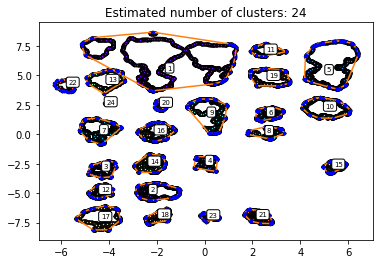

PointCloud loaded with 2159871 points
Maximum Height of Biomass Recorded 3.33 meters
Sampled points from slicing:  86839
number of estimated clusters : 24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


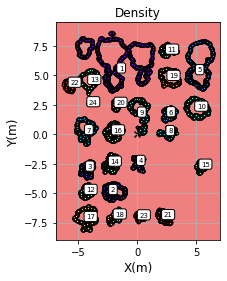

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.12121212121212122


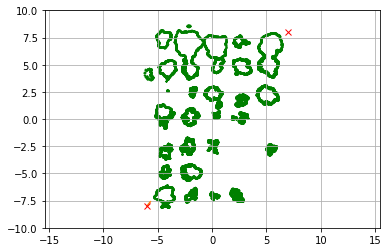

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.18326693227091634


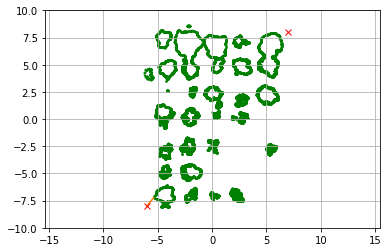

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.21468475658419792


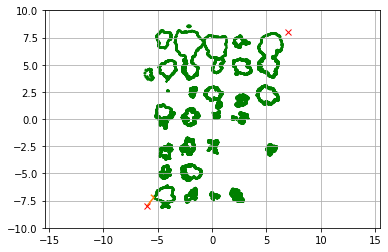

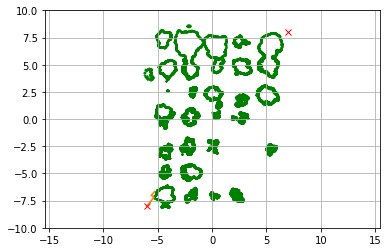

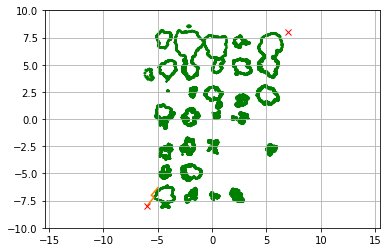

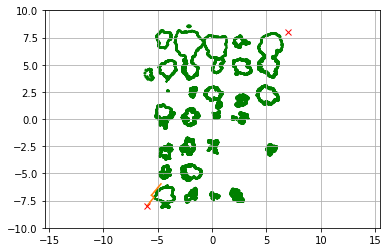

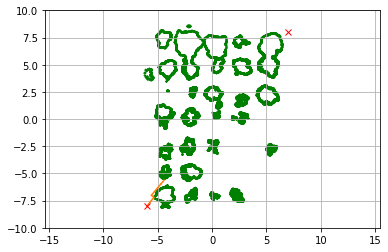

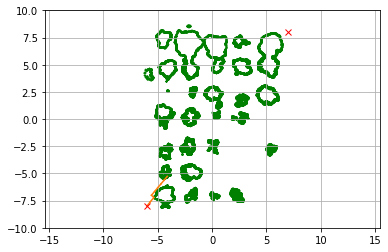

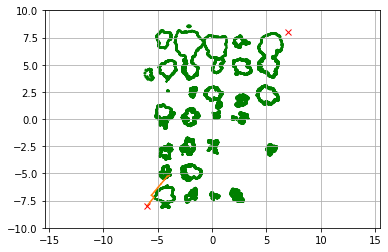

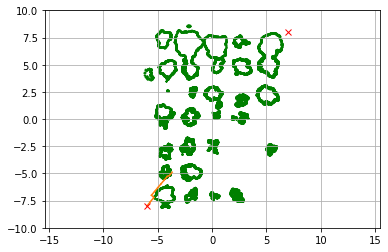

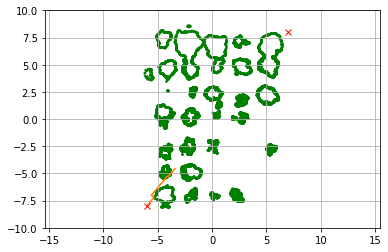

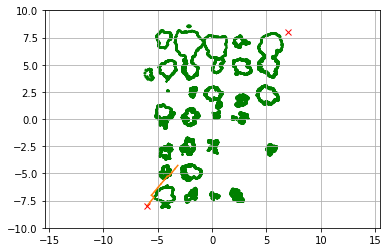

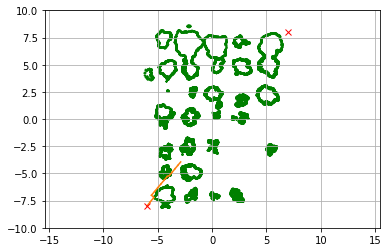

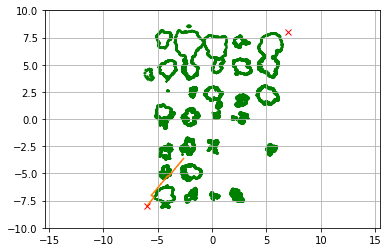

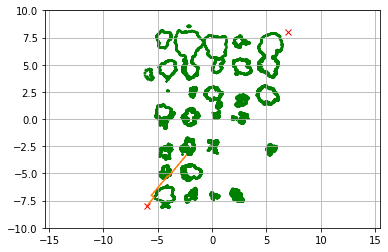

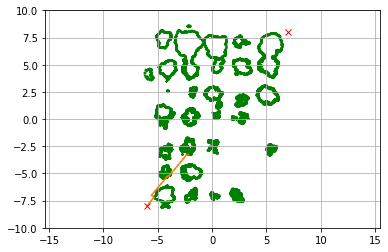

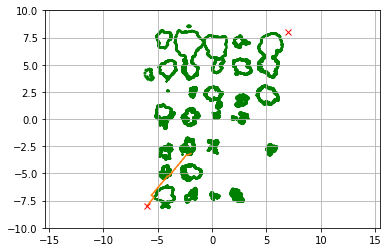

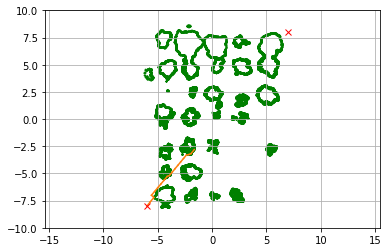

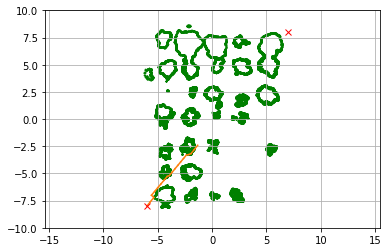

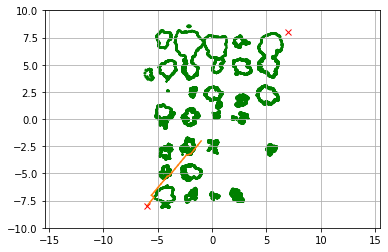

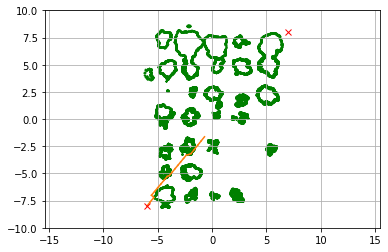

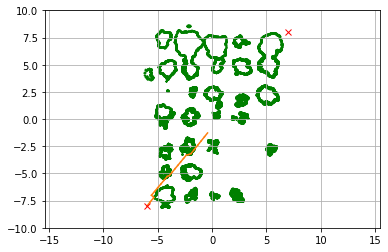

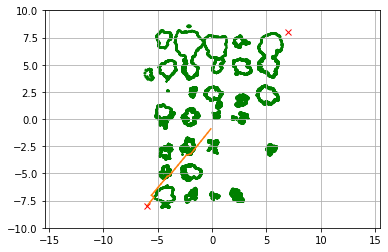

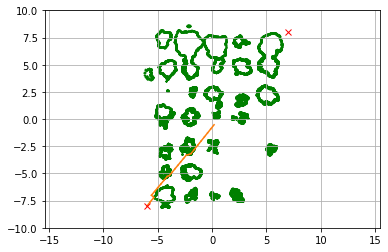

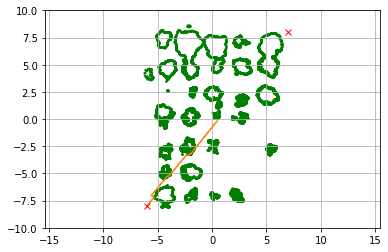

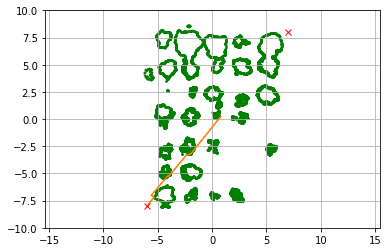

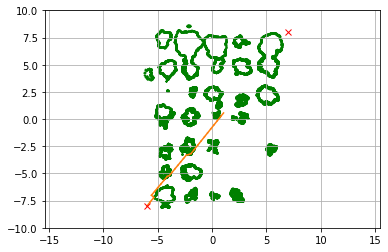

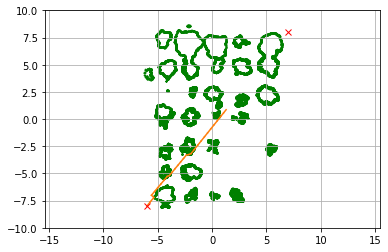

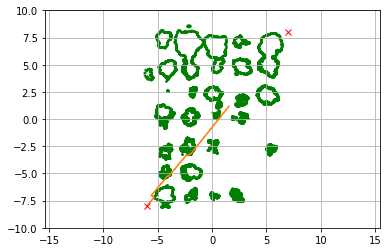

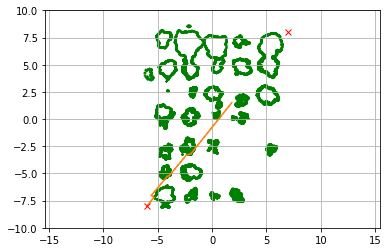

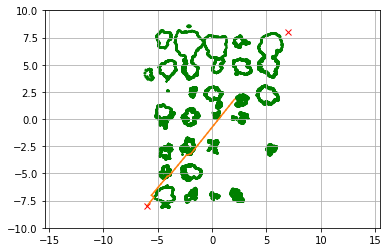

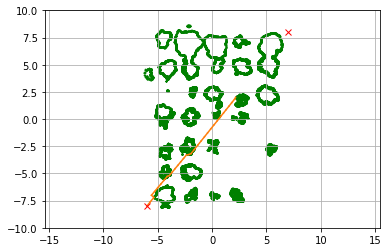

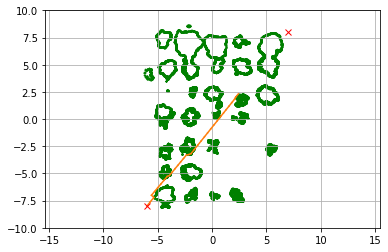

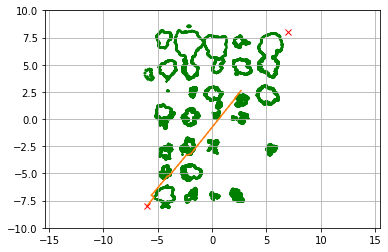

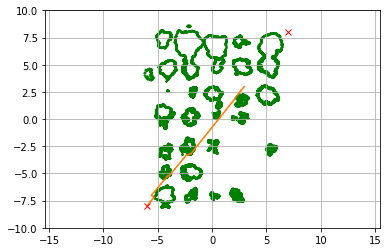

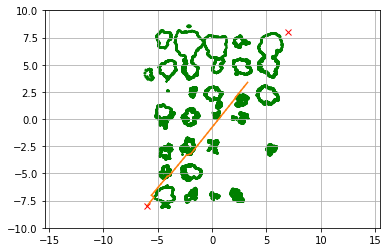

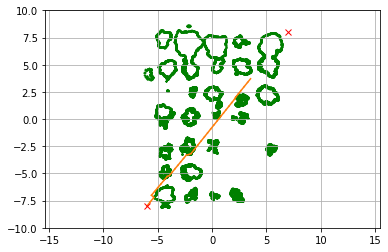

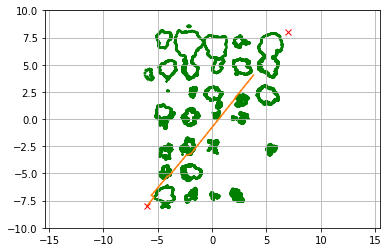

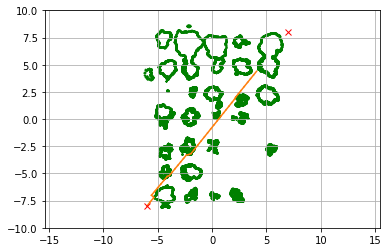

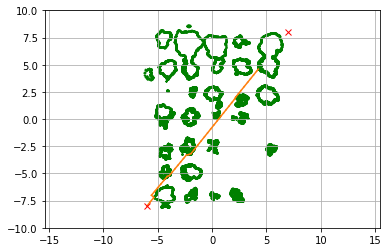

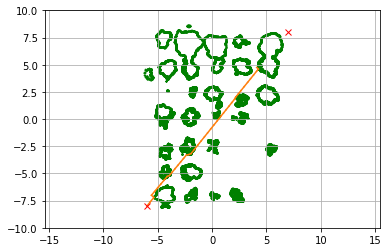

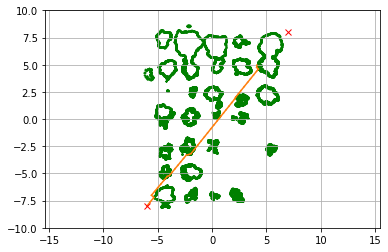

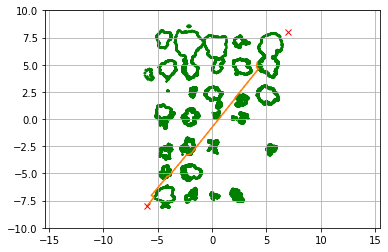

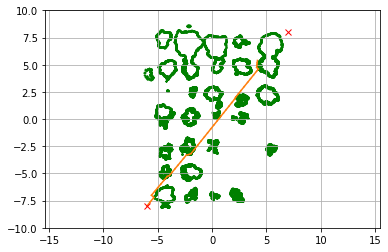

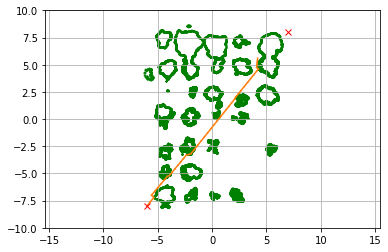

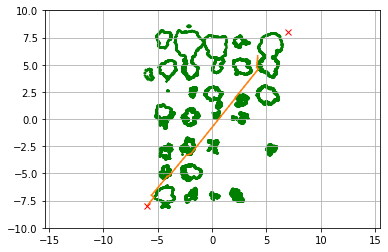

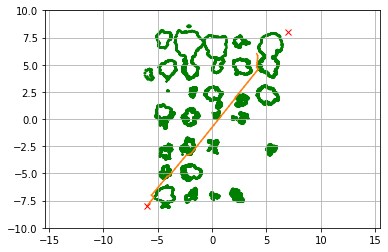

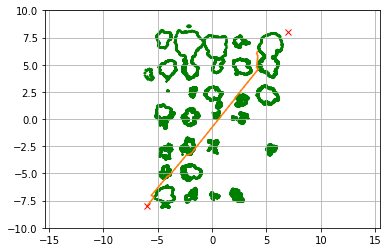

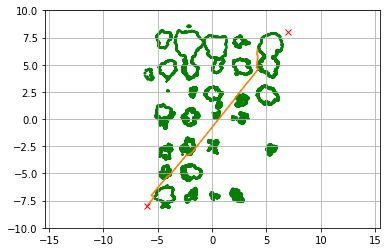

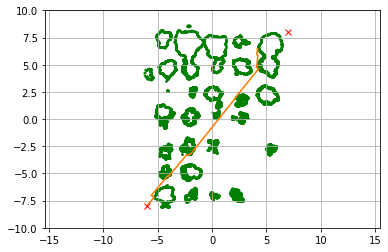

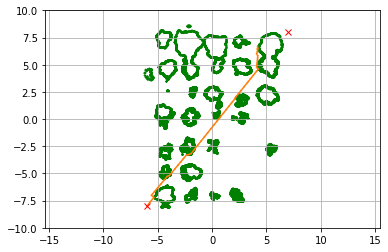

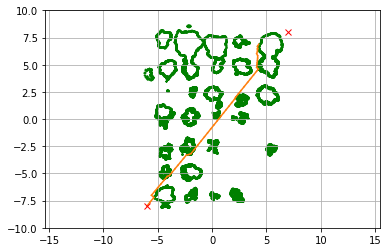

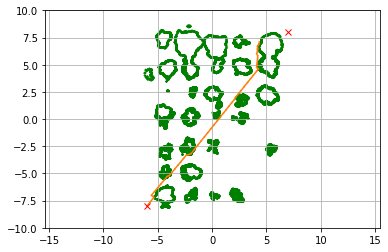

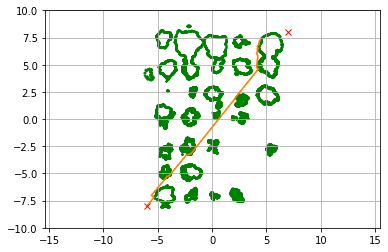

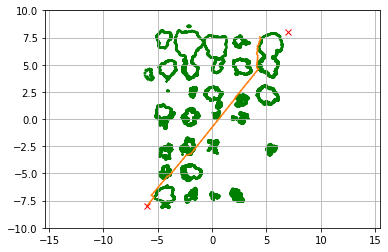

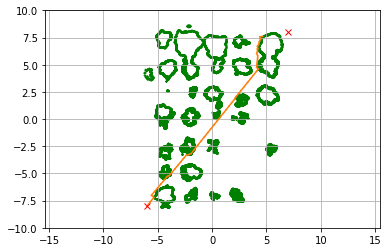

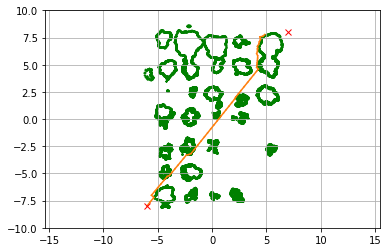

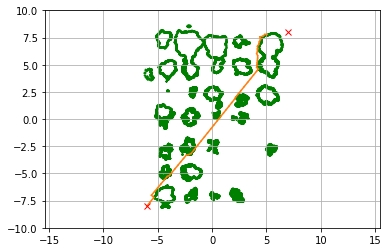

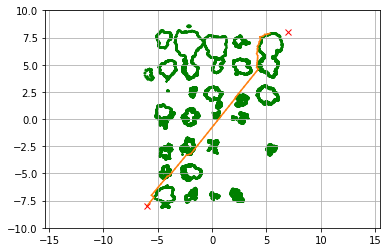

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.2900398406374502


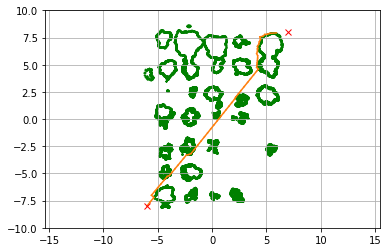

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.2597299444003177


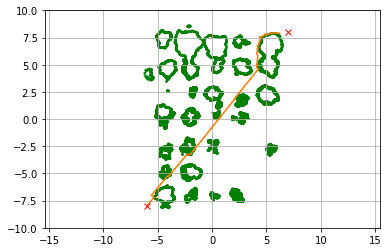

(-6, -8)  ->  [(-5.846838327697087, -7.811493326396414), (-5.748859115438213, -7.83590168769447), (-6.299959285717842, -8.004942358914743), (-6.10998080481707, -8.279113279103287), (-5.710439107040231, -7.921549446985115), (-5.7038858611219485, -8.048129167419663), (-6.151679825587169, -7.74116949463047), (-5.717742438864319, -8.101639899555918), (-5.80116837607752, -8.22464635614305), (-5.7240751895358875, -8.11775185336267), (-6.298893521700035, -8.025742235445875), (-5.817005685403944, -7.774776228189469), (-5.75022786884233, -7.692588146267484), (-6.187177236666656, -7.7655545221723505), (-5.7261374300536865, -8.122471599901367), (-5.9927953670568375, -8.299913476296338), (-5.820260500622231, -8.240195154745946), (-5.7328821244560375, -8.136557828647355), (-6.064808286106421, -7.707083824188645), (-6.043425821463003, -8.296840357819255), (-6.126508418090465, -7.727978640264688), (-5.729801940698925, -8.130357235126912), (-5.867498009885919, -7.73084721324904), (-6.288411143327297, 

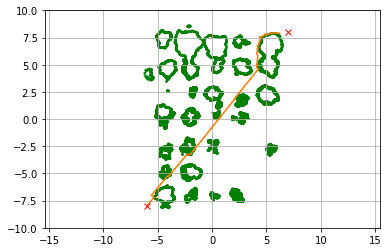

24
the initial path before rewiring is  [<__main__.Node object at 0x7f5f724c0550>, <__main__.Node object at 0x7f5f76b96b50>, <__main__.Node object at 0x7f5f76406310>, <__main__.Node object at 0x7f5f701fd950>, <__main__.Node object at 0x7f5f73f80bd0>, <__main__.Node object at 0x7f5f736c7e90>, <__main__.Node object at 0x7f5f76d3e4d0>, <__main__.Node object at 0x7f5f744caa90>, <__main__.Node object at 0x7f5f73ab2750>, <__main__.Node object at 0x7f5f7339edd0>, <__main__.Node object at 0x7f5f766eab50>, <__main__.Node object at 0x7f5f73fb1d50>, <__main__.Node object at 0x7f5f76956310>, <__main__.Node object at 0x7f5f769c11d0>, <__main__.Node object at 0x7f5f7687aa90>, <__main__.Node object at 0x7f5f765d3050>, <__main__.Node object at 0x7f5f7488b950>, <__main__.Node object at 0x7f5f7687a6d0>, <__main__.Node object at 0x7f5f74b52f90>, <__main__.Node object at 0x7f5f74916350>, <__main__.Node object at 0x7f5f739000d0>, <__main__.Node object at 0x7f5f6fb4db90>, <__main__.Node object at 0x7f5f6fb2

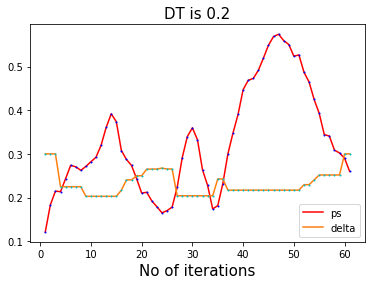

Mean of ps values is  0.328194135479822
found path!!
All the grids belong to the same cluster with delta 0.3 and obstacle density 0.12121212121212122


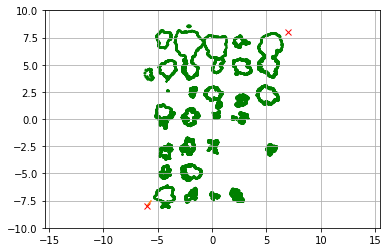

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.19142176330420968


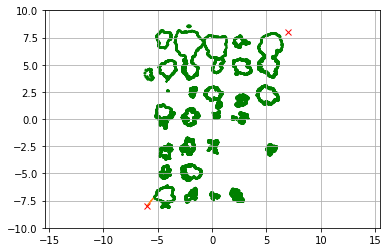

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.21371610845295055


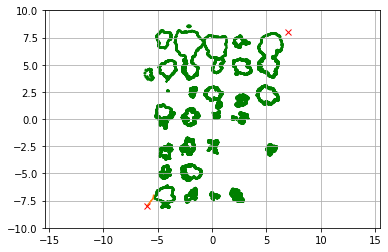

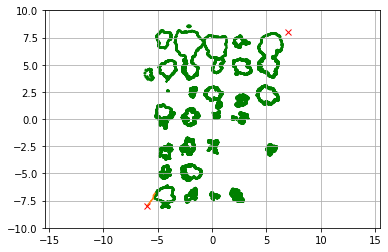

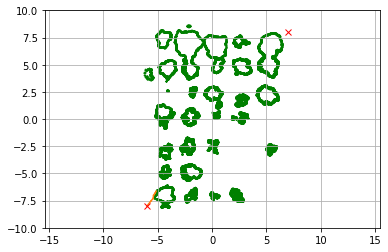

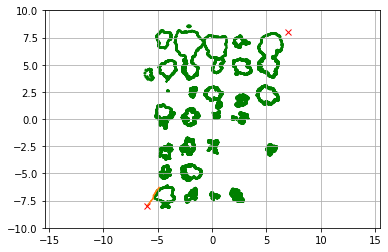

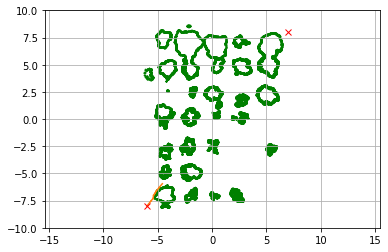

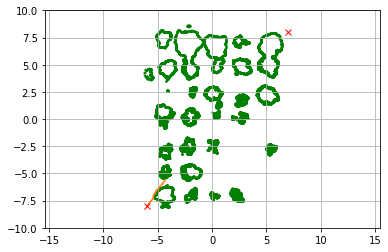

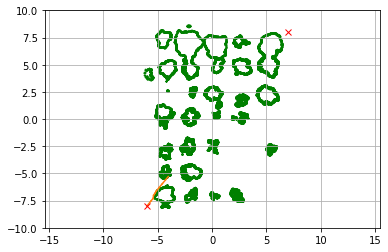

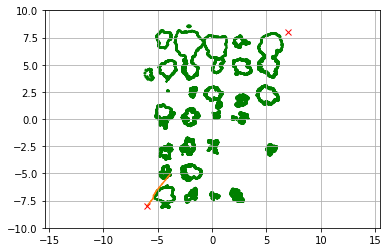

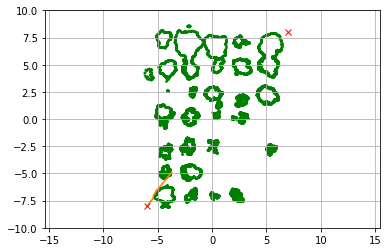

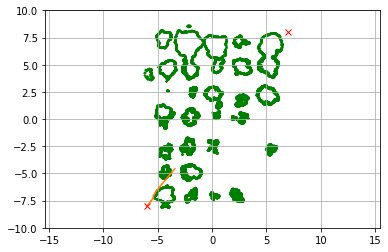

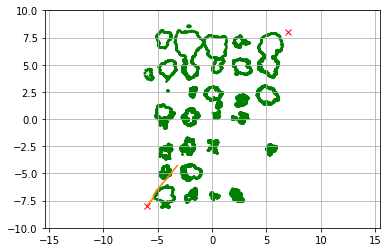

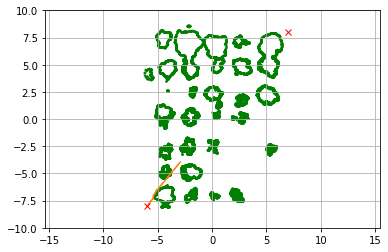

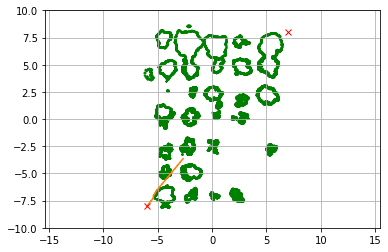

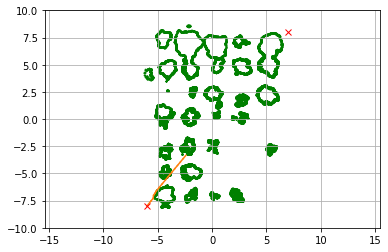

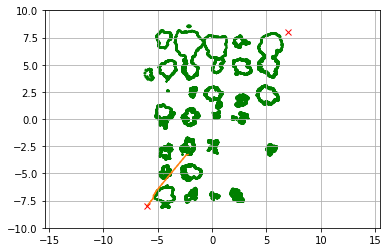

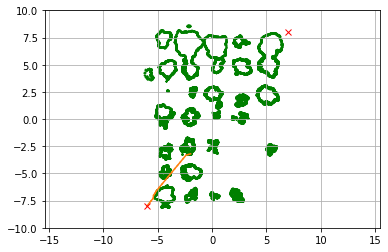

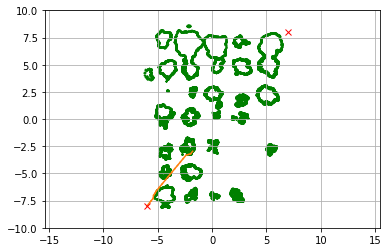

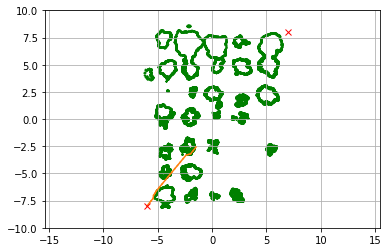

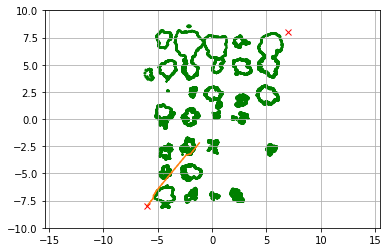

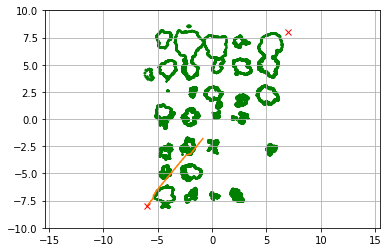

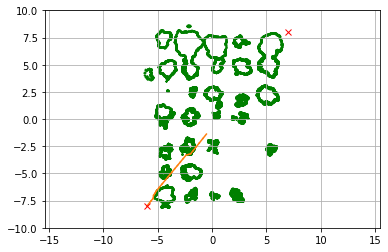

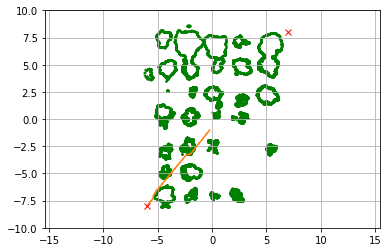

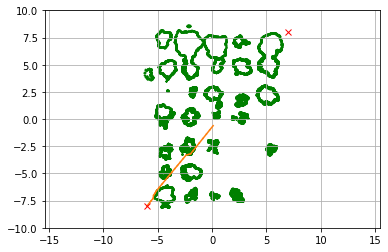

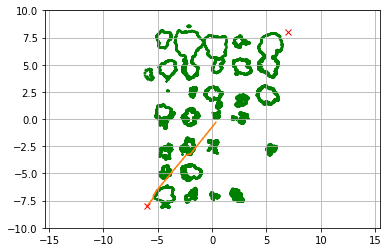

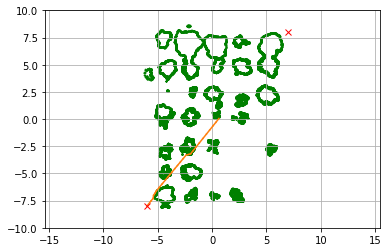

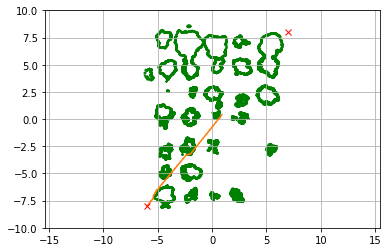

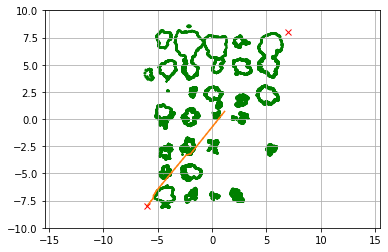

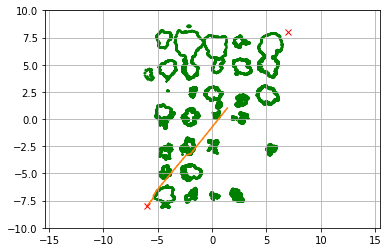

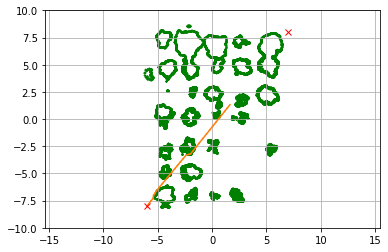

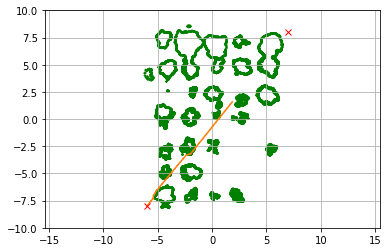

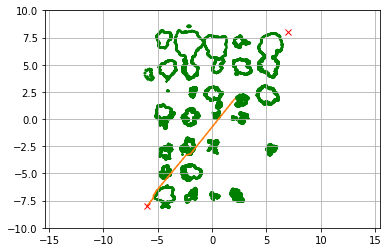

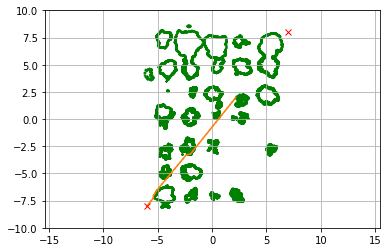

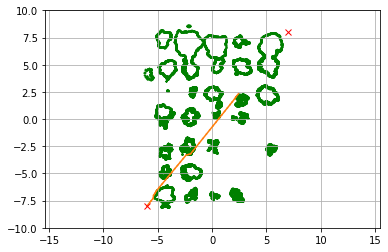

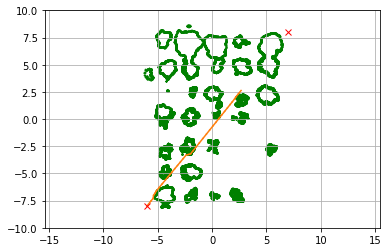

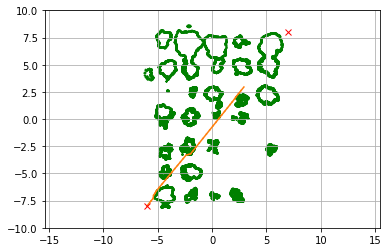

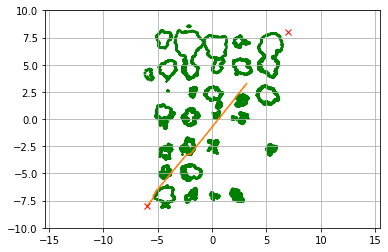

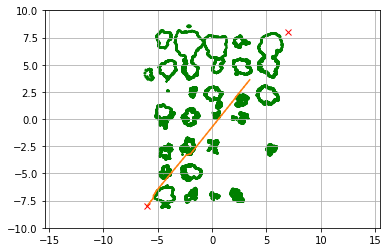

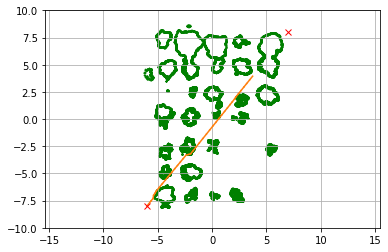

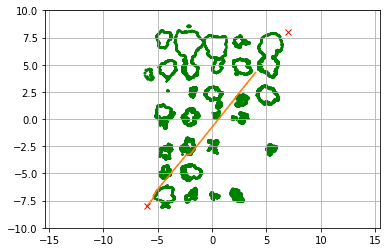

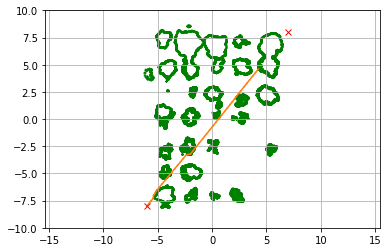

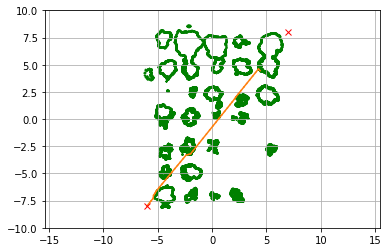

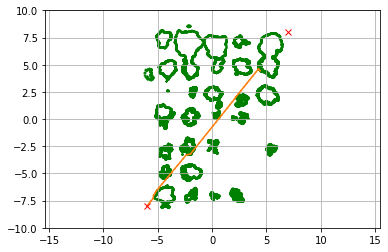

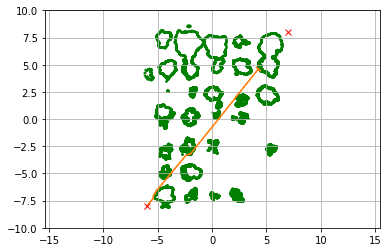

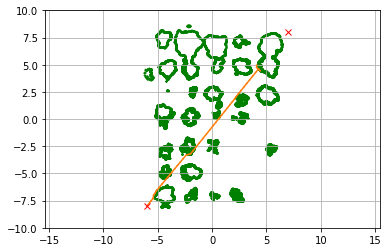

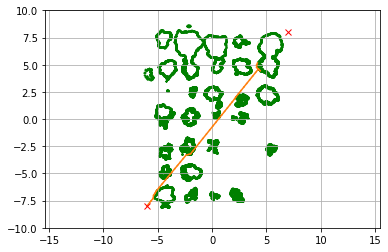

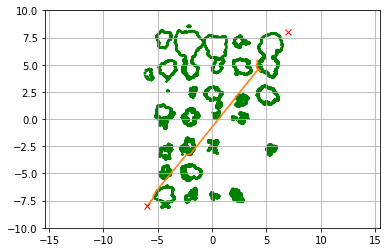

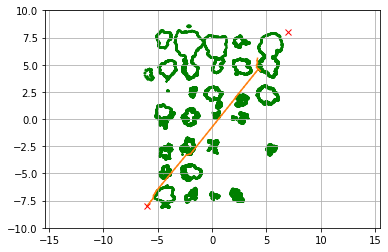

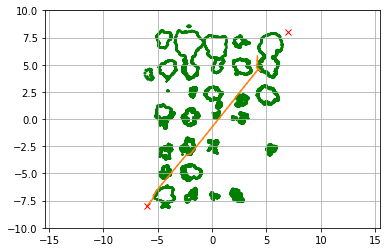

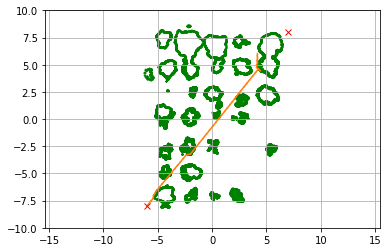

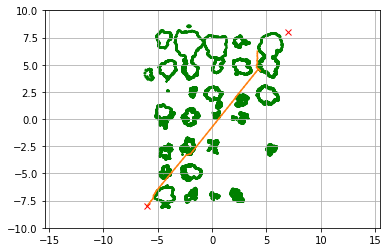

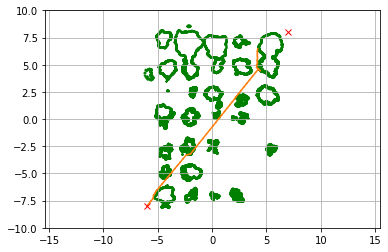

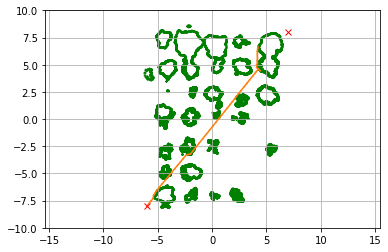

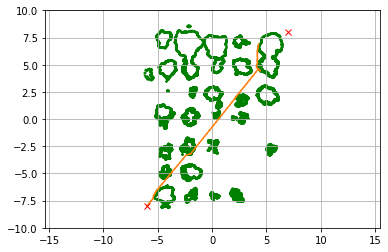

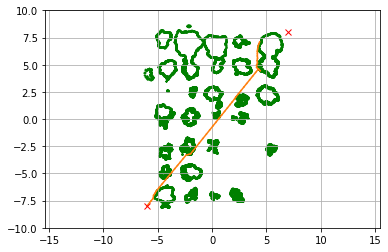

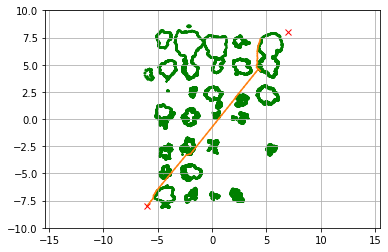

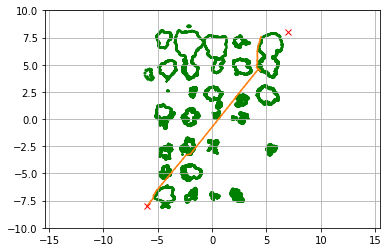

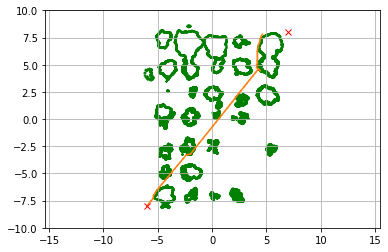

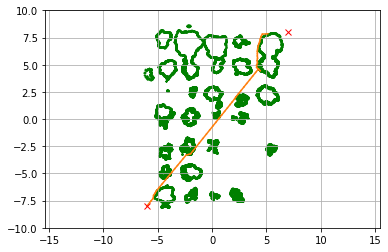

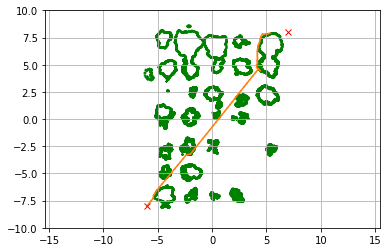

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.28378378378378377


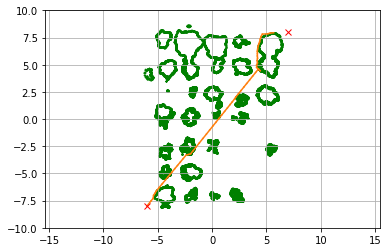

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.27380952380952384


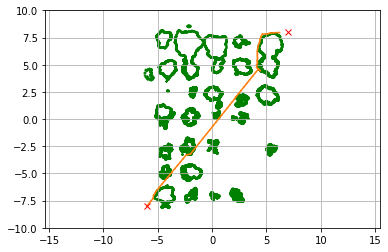

(-6, -8)  ->  [(-5.818229893517287, -7.761337836284711), (-6.2690476040516625, -7.867284564748256), (-5.808554305155443, -8.230973041555687), (-5.681626684952224, -7.608155919941199), (-6.299394126558459, -8.019056678154849), (-6.265196355735218, -8.140252960413532), (-6.299696413167302, -8.01349295870644), (-5.703329751495868, -8.044573127021744), (-6.243581086419307, -7.82487645978113), (-6.105946728865954, -8.28066936178109), (-6.279086795315756, -8.110047992623134), (-6.20378763388575, -8.220160396700331), (-5.718410364247639, -7.896524026765378), (-5.740177827809158, -7.680218864995887), (-5.850641095250799, -7.81617365569329), (-6.121641858970659, -7.725767875430025), (-6.291605444904498, -8.07047172838841), (-6.021203150926247, -7.7007502274172985), (-5.741331018565123, -7.681638176695536), (-6.298057722082143, -8.034082169930977), (-5.766398941516438, -7.712491004943309), (-5.734076308031698, -7.861131032804491), (-5.773920645910234, -7.721748487274134), (-6.25002496922138, -7.

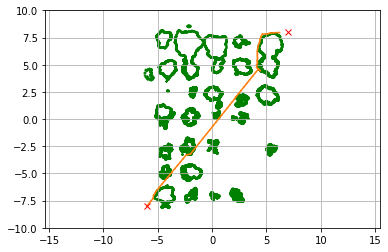

24
the initial path before rewiring is  [<__main__.Node object at 0x7f5f73ac1710>, <__main__.Node object at 0x7f5f743d4510>, <__main__.Node object at 0x7f5f728f1610>, <__main__.Node object at 0x7f5f736bedd0>, <__main__.Node object at 0x7f5f6e61ff50>, <__main__.Node object at 0x7f5f736bead0>, <__main__.Node object at 0x7f5f76b81450>, <__main__.Node object at 0x7f5f6fb1fd90>, <__main__.Node object at 0x7f5f765b38d0>, <__main__.Node object at 0x7f5f7694bd10>, <__main__.Node object at 0x7f5f76699950>, <__main__.Node object at 0x7f5f769f7c90>, <__main__.Node object at 0x7f5f74500250>, <__main__.Node object at 0x7f5f72168a10>, <__main__.Node object at 0x7f5f6f3499d0>, <__main__.Node object at 0x7f5f7662fc90>, <__main__.Node object at 0x7f5f6f54c910>, <__main__.Node object at 0x7f5f6e7adfd0>, <__main__.Node object at 0x7f5f6fc6b050>, <__main__.Node object at 0x7f5f73d79a10>, <__main__.Node object at 0x7f5f717d9690>, <__main__.Node object at 0x7f5f747d4e50>, <__main__.Node object at 0x7f5f6f65

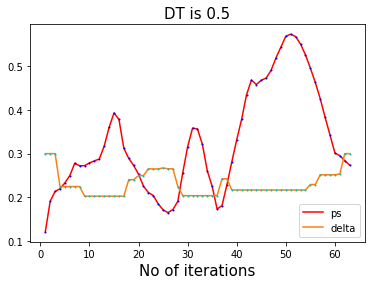

Mean of ps values is  0.32654269147231985
found path !
All the grids belong to the same cluster with delta 0.3 and obstacle density 0.12121212121212122


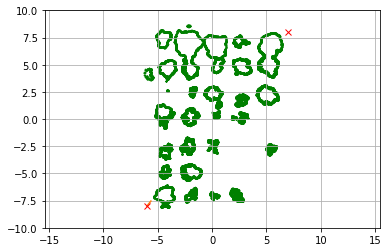

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.1907790143084261


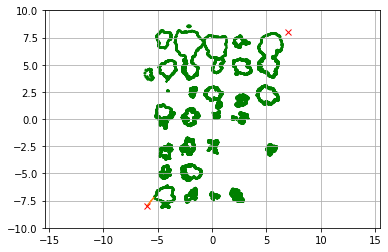

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.21400159108989658


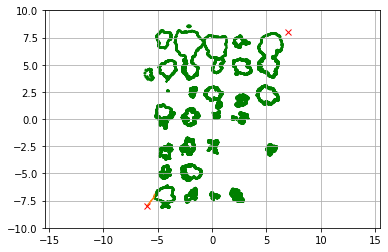

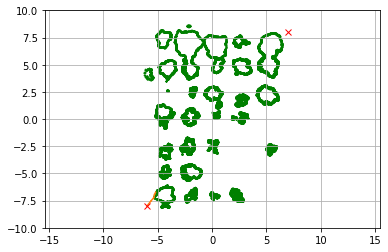

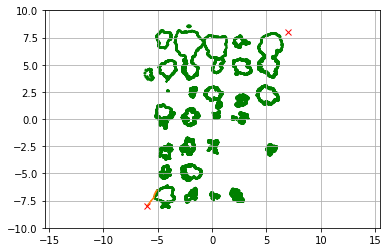

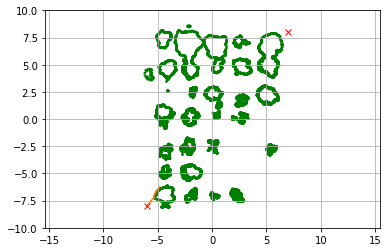

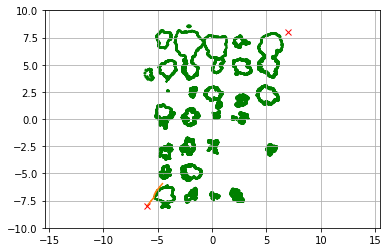

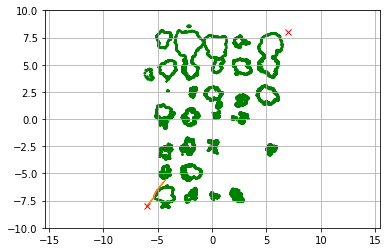

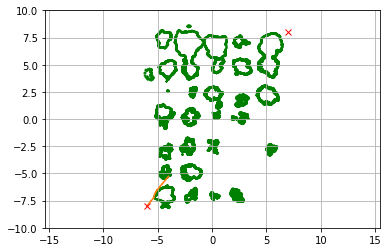

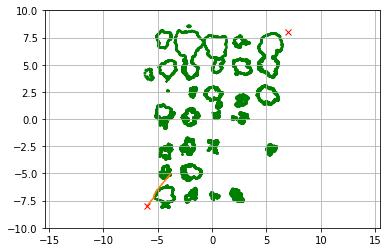

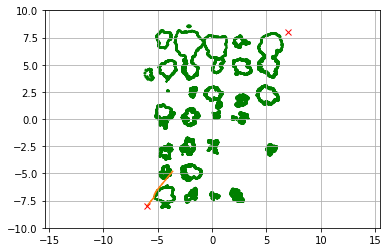

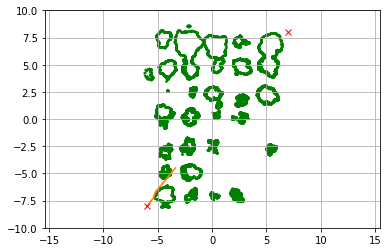

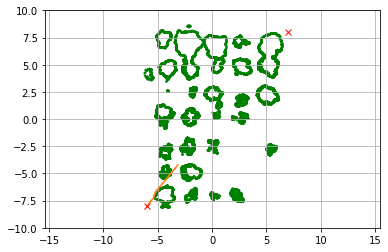

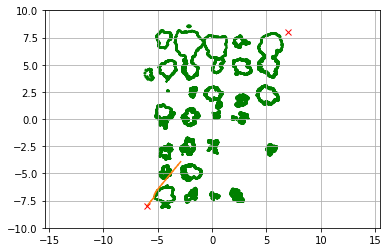

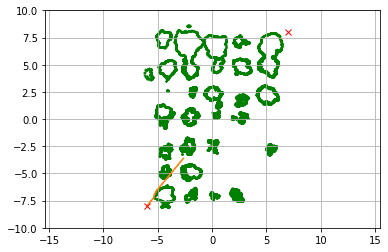

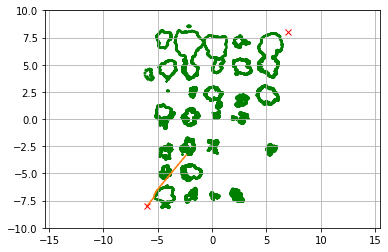

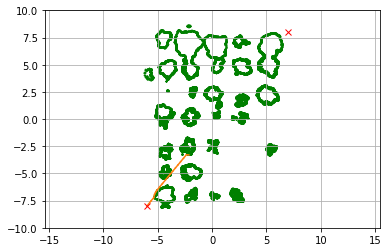

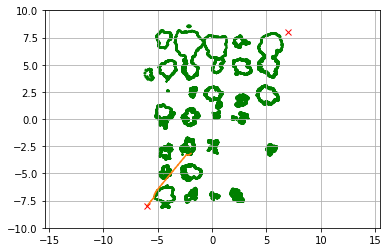

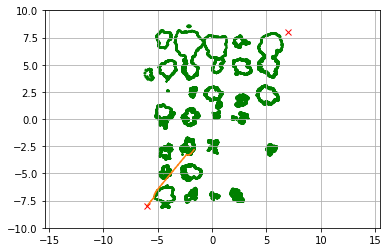

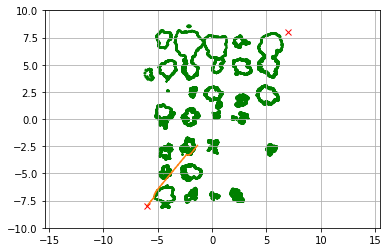

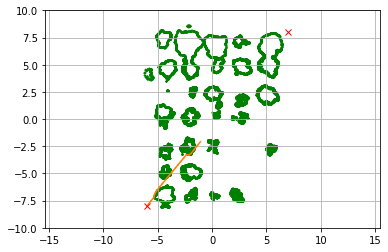

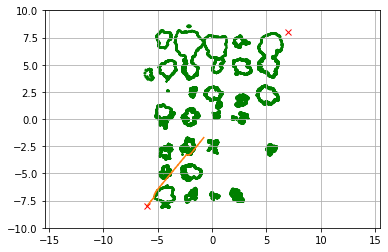

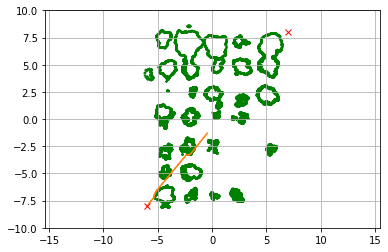

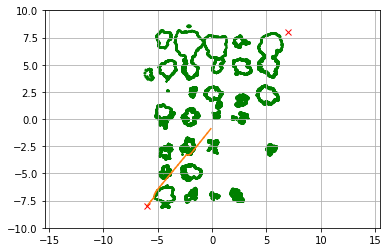

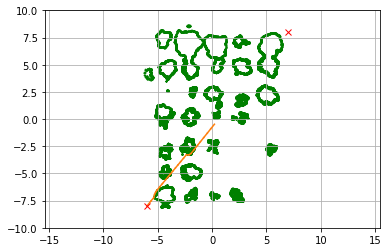

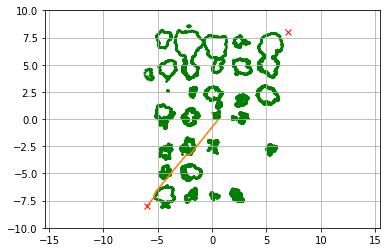

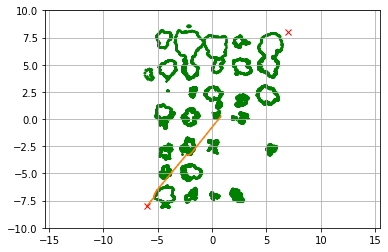

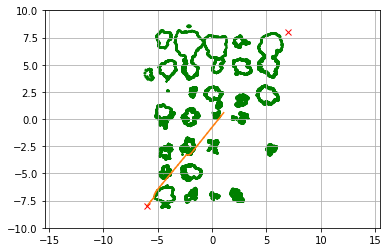

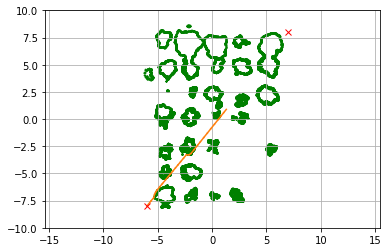

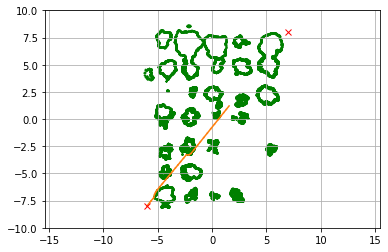

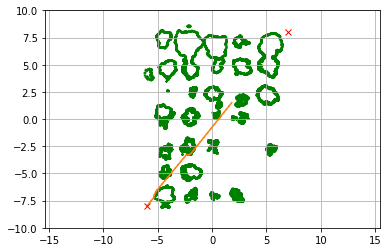

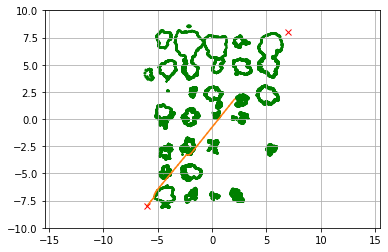

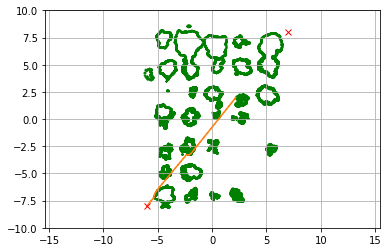

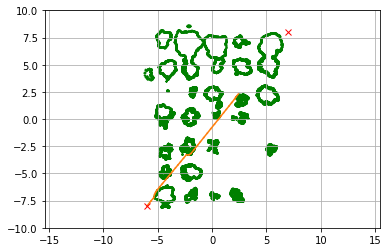

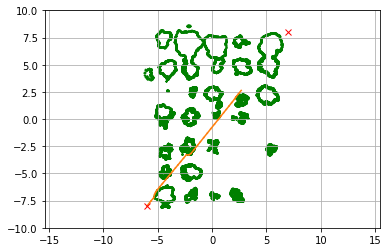

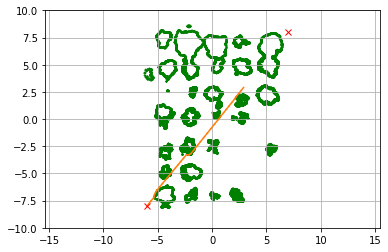

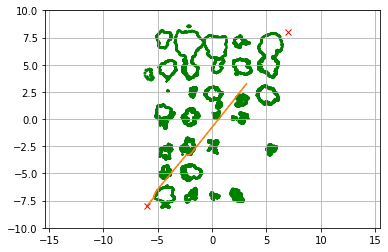

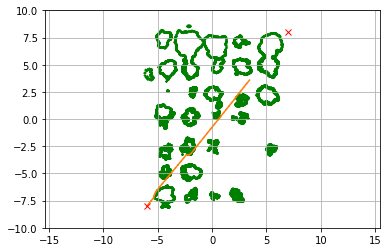

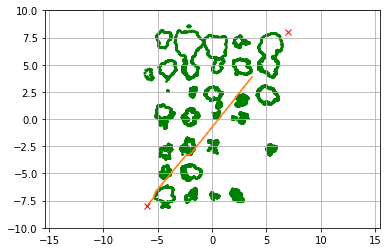

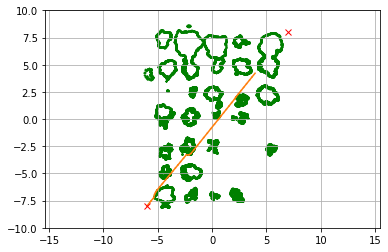

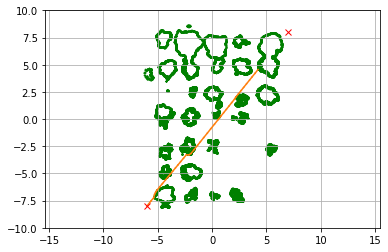

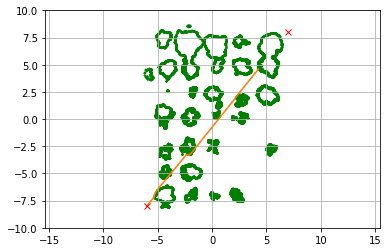

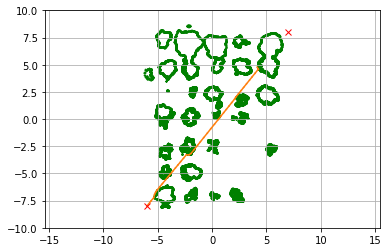

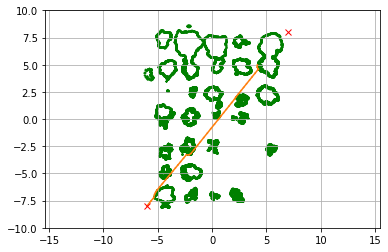

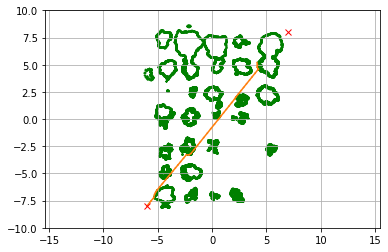

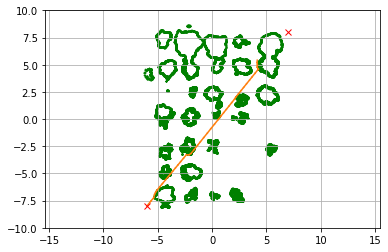

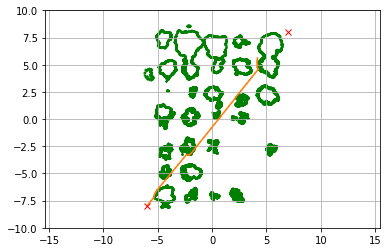

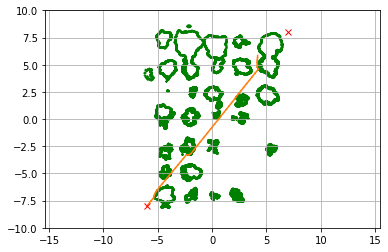

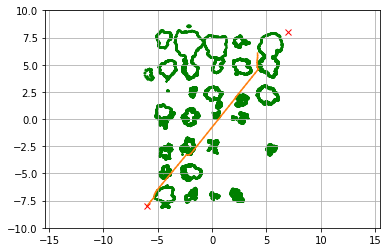

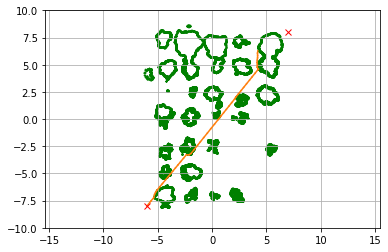

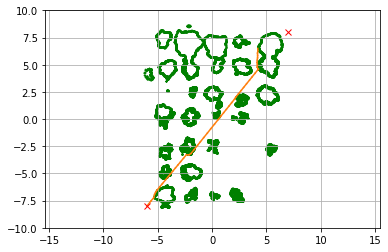

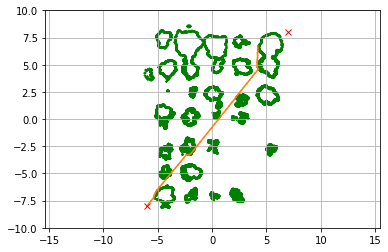

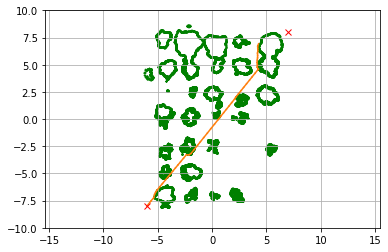

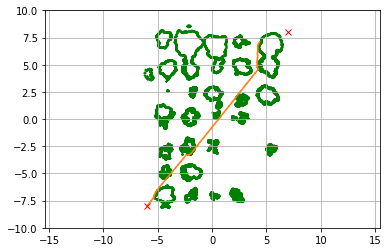

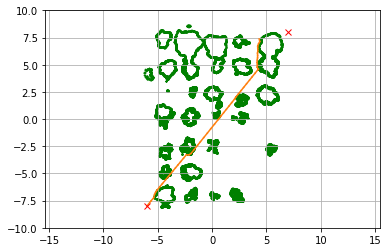

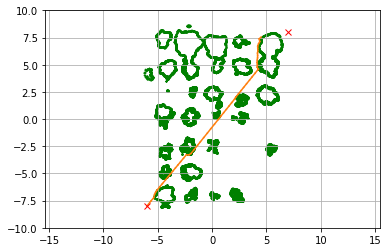

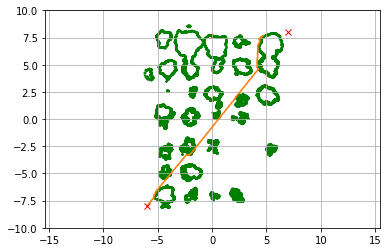

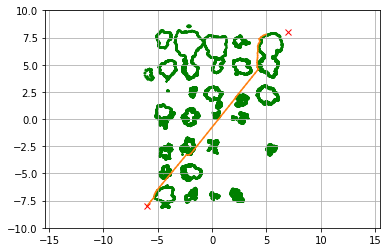

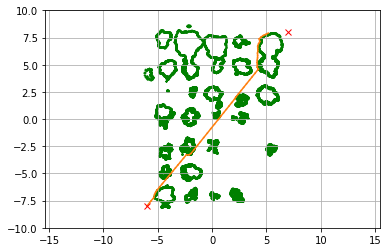

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.28378378378378377


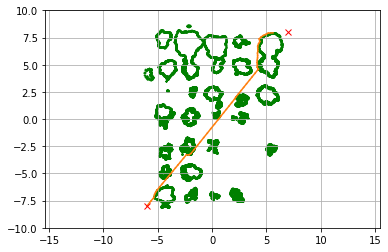

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.2762738853503185


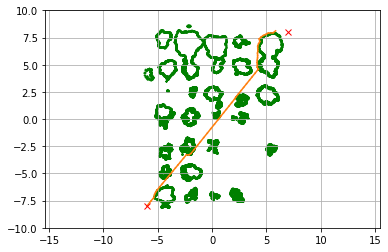

All the grids belong to the same cluster with delta 0.3 and obstacle density 0.236


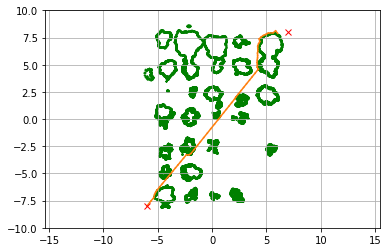

(-6, -8)  ->  [(-5.930191241862671, -7.914081528446364), (-6.057538429020395, -7.7055694832632575), (-5.700676268255549, -7.979867846250938), (-5.790564991870365, -8.214795198665472), (-6.1912477659580025, -8.231136955106866), (-6.013788710047492, -8.299682951592557), (-6.065992173517511, -7.7073482734812), (-6.162923046402389, -8.25190490457902), (-6.272687663161628, -8.125065736152834), (-5.916746702498149, -7.7117832613204635), (-6.114125712792072, -8.277444267700202), (-6.032795387064461, -7.701797950061888), (-6.268607135746735, -8.133604665434763), (-6.032491524057009, -7.7017646887700035), (-5.782797070488779, -7.793063083497064), (-5.89170212892599, -8.279770568718078), (-5.6574606220344075, -7.578413073273117), (-6.111759005669575, -8.27840604277161), (-5.642996550488051, -7.560611139062216), (-5.897761343400216, -8.282041232972542), (-6.067171186911003, -7.707616635820423), (-5.8575887847455785, -8.264043643683689), (-6.010871323035103, -7.700197040816028), (-5.76639516937148

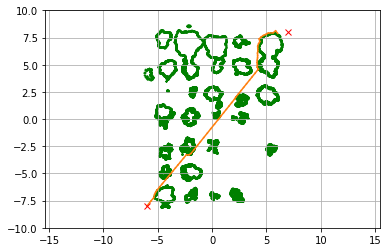

24
the initial path before rewiring is  [<__main__.Node object at 0x7f5f736bec50>, <__main__.Node object at 0x7f5f6e8467d0>, <__main__.Node object at 0x7f5f6fb66b50>, <__main__.Node object at 0x7f5f715212d0>, <__main__.Node object at 0x7f5f731c8ad0>, <__main__.Node object at 0x7f5fba5cb350>, <__main__.Node object at 0x7f5f776f79d0>, <__main__.Node object at 0x7f5f731b6b50>, <__main__.Node object at 0x7f5f71146b90>, <__main__.Node object at 0x7f5f731b6390>, <__main__.Node object at 0x7f5f70bc0f90>, <__main__.Node object at 0x7f5f72bf2b90>, <__main__.Node object at 0x7f5f7365ff50>, <__main__.Node object at 0x7f5f76699610>, <__main__.Node object at 0x7f5f76699ed0>, <__main__.Node object at 0x7f5f6e88e090>, <__main__.Node object at 0x7f5f73b049d0>, <__main__.Node object at 0x7f5f6e867c10>, <__main__.Node object at 0x7f5f70ec0a10>, <__main__.Node object at 0x7f5f73bbeb10>, <__main__.Node object at 0x7f5f70ec0710>, <__main__.Node object at 0x7f5f6f5d3550>, <__main__.Node object at 0x7f5f6fb1

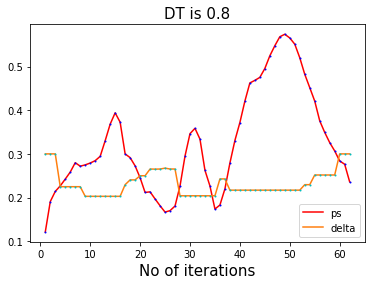

Mean of ps values is  0.3245617941821757
found path!


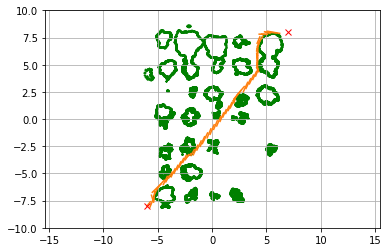

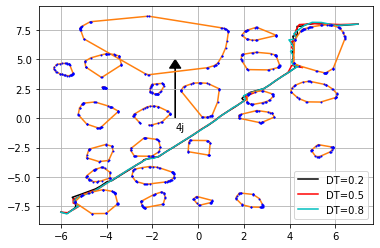

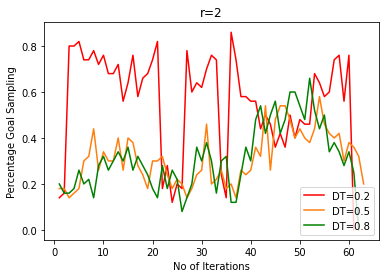

In [ ]:
if __name__=="__main__":
  # Loading Point Cloud File
    pcd_load = o3d.io.read_point_cloud("/content/1fTgso1os7j0DYpymx9jAKRZpuSmCjq2H.ply")
    #pcd_load = o3d.io.read_point_cloud("/content/1InLxHVI_WKzVBsH6WiVSL5eg6_ZhYNbj.ply")

    clus = get_labeled_cluster_dict( pcd_load, operating_height )
    dd=generate_A_b_padding(clus,0)
    pp=return_boundarypts_dict(clus)
    # dic={}
    # for i in range(24):
    #   A=dd["A"+str(i)]
    #   B=dd["B"+str(i)]
    #   #print("A is ",A[0])
    #   x,y=symbols('x,y')
    #   hull_vertices=[]
    #   for row in range(A.shape[0]):
    #     eq1=Eq(((A[row][0]*x)+(A[row][1]*y)),B[row][0])
    #     if row==A.shape[0]-1:
    #       #print("row no is this ",row)
    #       eq2=Eq(((A[0][0]*x)+(A[0][1]*y)),B[0][0])
    #     else:
    #       eq2=Eq(((A[row+1][0]*x)+(A[row+1][1]*y)),B[row+1][0])
    #     sol_dict=solve((eq1, eq2), (x, y))
    #     hull_vertices.append((sol_dict[x],sol_dict[y]))
    #     dic[i]=hull_vertices

    # print("Dictionary is ",dic[0])
    # print("yes")

    # for i in range(24):
    #   plt.plot([x for (x,y) in dic[i]],[y for (x,y) in dic[i]],'-r')
    #   plt.plot([x for (x,y) in dic[i]],[y for (x,y) in dic[i]],'bo',markersize=2)
    # plt.show()

    #print(len(clus))
    #PP=generate_boundary(clus)
    # boundary_points=return_boundary_pts(clus)
    # print(np.shape(boundary_points))
    # print(boundary_points)
    for key in pp.keys():
      plt.plot([x for (x,y) in pp[key]],[y for (x,y) in pp[key]],'tab:orange')
      plt.plot([x for (x,y) in pp[key]],[y for (x,y) in pp[key]],'bo',markersize=2)
    plt.show()

    # for key in pp.keys():
    #   print("first vertice of cluster ",pp[key][0])
    #   print("last vertice of cluster ",pp[key][-1])
    # Based on the POV, aligning and centering pointcloud
    R = pcd_load.get_rotation_matrix_from_xyz((-np.pi, 0, 0))
    pcd_load_centered = copy.deepcopy(pcd_load).translate((0, 0, 0), relative=False)
    pcd_load_rotated = pcd_load_centered.rotate(R, center=(0,0,0))
    height_correction =(np.asarray(pcd_load_rotated.points)[:, 2]).min()
    pcd_load_transformed = copy.deepcopy(pcd_load_rotated).translate((0, 0, -height_correction), relative=False)

    # Centered and Aligned Pointcloud
    xyz_load = np.asarray(pcd_load_transformed.points)
    print('PointCloud loaded with', len(xyz_load), 'points')

    # Respective points
    x_pcd = xyz_load[:, 0]
    y_pcd = xyz_load[:, 1]
    z_pcd = xyz_load[:, 2]
    x_lim = [x_pcd.min(), x_pcd.max()]
    y_lim = [y_pcd.min(), y_pcd.max()]
    print("Maximum Height of Biomass Recorded", round(z_pcd.max() - z_pcd.min(), 2), "meters")

    ### Point Cloud Loaded ###
    thickness = 0.05 # Farm_meshed
    hull_points= []
    hull_areas= []

    # Slicing
    sliced_pts = slice(operating_height, thickness, xyz_load)
    #print(sliced_pts)
    grid = plot_grid(sliced_pts)

    # Clustering using DBSCAN
    cluster = clustering(sliced_pts)
    # res = {}
    # for i, v in cluster:
    #   res[v] = [i] if v not in res.keys() else res[v] + [i]
    # print(res)
    # sorted_res=sorted(res.items())
    # dd=generate_A_b_padding(sorted_res,0)
    # Read the data from the file
    # with open('/content/saved_dictionary.pkl', 'rb') as fid:
    #   dd = pickle.load(fid)
    #print(dd["B0"])

    # Plot Labels
    plt.xlabel('X(m)', fontsize=12)
    plt.ylabel('Y(m)', fontsize=12)
    title = 'Density'
    filename = title.lower().replace(" ", "_")
    plt.grid()
    plt.title(title, fontsize=12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.scatter(0, 0, marker='x', color='black')
    ax = plt.axes()
    ax.set(facecolor = "lightcoral")
    path = './'
    plt.savefig(path+filename+ '.png', dpi=500)
    plt.show()

    #RRT algorithm
    # result=[[1 for i in np.arange(-10,10.2,0.2)] for i in np.arange(-10,10.2,0.2)]
    # print(result)
    grids=[]
    for i in np.arange(-10,10.001,0.1):
      for j in np.arange(-10,10.001,0.1):
        grid=Node(i,j)
        if check_collision(grid,dd)==False:
          grid.cluster=get_cluster_label(grid,dd)
          grid.value=0
        grids.append(grid)

    #plt.scatter([node.x for node in grids if node.value==0],[node.y for node in grids if node.value==0],'r')
    #plt.scatter([node.x for node in grids if node.value==1],[node.y for node in grids if node.value==1],'b')

    plt.show()
    rrt_lower = xyz(
        start=[-6, -8],
        goal=[7, 8],
        obstacle_list=dd,boundary_pts=pp,sliced_pts=sliced_pts,rasterized_map=grids,alpha=0.5,beta=0.5,steplength=0.3,DT=0.2)
    path_lower,rewired_path_lower,iterations_lower,percentages_goal_lower = rrt_lower.planning()

    #length1=[cal_pathlength(path[i],path[i+1]) for i in range(len(path)-1)]

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")

    rrt_equal=xyz(start=[-6,-8],goal=[7,8],obstacle_list=dd,boundary_pts=pp,sliced_pts=sliced_pts,rasterized_map=grids,alpha=0.5,beta=0.5,steplength=0.3,DT=0.5)
    path_equal,rewired_path_equal,iterations_equal,percentages_goal_equal=rrt_equal.planning()
    #length2=[cal_pathlength(path_withoutwind[i],path_withoutwind[i+1]) for i in range(len(path_withoutwind)-1)]

    if path_equal is None:
      print("Cannot find path")

    else:
        print("found path !")

    rrt_upper=xyz(start=[-6,-8],goal=[7,8],obstacle_list=dd,boundary_pts=pp,sliced_pts=sliced_pts,rasterized_map=grids,alpha=0.5,beta=0.5,steplength=0.3,DT=0.8)
    path_upper,rewired_path_upper,iterations_upper,percentages_goal_upper=rrt_upper.planning()
    #length3=[cal_pathlength(path_upper[i],path_upper[i+1]) for i in range(len(path_upper)-1)]
    if path_upper is None:
      print("Cannot")

    else:
        print("found path!")
        #Draw final path
        if show_animation:
            rrt_lower.draw_graph()
            #plot_grid(sliced_pts)
            #plt.plot([x for (x,y) in boundary_points],[y for (x,y) in boundary_points],'yo')
            plt.plot([node.x for node in rewired_path_lower], [node.y for node in rewired_path_lower], '-k',label='DT=0.2')
            #plt.plot([x for (x,y) in path],[y for (x,y) in path],'bo',markersize=2)
            plt.plot([node.x for node in rewired_path_equal],[node.y for node in rewired_path_equal],'-r',label='DT=0.5')
            #plt.plot([x for (x,y) in path_withoutwind],[y for (x,y) in path_withoutwind],'bo',markersize=2)
            plt.plot([node.x for node in rewired_path_upper], [node.y for node in rewired_path_upper],'-c',label='DT=0.8')
            for key in pp.keys():
              plt.plot([x for (x,y) in pp[key]],[y for (x,y) in pp[key]],'tab:orange')
              plt.plot([x for (x,y) in pp[key]],[y for (x,y) in pp[key]],'bo',markersize=1)

            plt.legend(loc="lower right")
            plt.grid(True)
            plt.arrow(x=-1.0,y=0.0,dx=0,dy=5,head_width = 0.5,length_includes_head = True,lw=1,color='black')
            plt.text(x=-1,y=-1,s="4j")
            #plt.arrow(x=1.0,y=-3.0,dx=5,dy=0,head_width = 0.5,length_includes_head = True,lw=1,color='black')
            #plt.text(x=1,y=-4,s="4i")
            plt.figure()
            plt.plot([iteration for iteration in iterations_lower],[goalpercent for goalpercent in percentages_goal_lower],'-r',label='DT=0.2')
            #plt.plot([iteration for iteration in iterations_lower],[goalpercent for goalpercent in percentages_goal_lower],'bo',markersize=0.5)
            plt.plot([iteration for iteration in iterations_equal],[goalpercent for goalpercent in percentages_goal_equal],'tab:orange',label='DT=0.5')
            #plt.plot([iteration for iteration in iterations_equal],[goalpercent for goalpercent in percentages_goal_equal],'co',markersize=0.5)
            plt.plot([iteration for iteration in iterations_upper],[goalpercent for goalpercent in percentages_goal_upper],'-g',label='DT=0.8')
            #plt.plot([iteration for iteration in iterations_upper],[goalpercent for goalpercent in percentages_goal_upper],'ko',markersize=0.5)
            plt.xlabel('No of Iterations')
            plt.ylabel('Percentage Goal Sampling')
            plt.title('r=2')
            plt.legend(loc="lower right")
            #plt.grid(True)
            #plt.pause(0.01)  # Need for Mac
            plt.show()
            #print(path_withoutwind)
            # print("Length of DT=0.2 is ",np.sum(length1))
            # print("Length of DT=0.5 is ",np.sum(length2))
            # print("Length of DT=0.8 is ",np.sum(length3))

In [ ]:
def plot_graph(graph_edges, path,rewired_path):
  graph_edges_arr = np.array(graph_edges)

  formatted_graph = []
  for i in range(len(graph_edges_arr)):
    formatted_graph.append([graph_edges_arr[i, :, 0],graph_edges_arr[i, :, 1]])

  formatted_graph = np.array(formatted_graph)

  f = plt.figure()
  f.set_figwidth(40)
  f.set_figheight(40)

  plt.plot(formatted_graph[:,0,:].transpose(), formatted_graph[:,1,:].transpose(), '-', color = [0,1,0])
  plt.plot([node.x for node in path], [node.y for node in path], '-k',label='initial path')
  plt.plot([node.x for node in rewired_path],[node.y for node in rewired_path],'-r',label='rewired path')
  plt.legend(loc="lower right")

  for i in range(len(graph_edges_arr)):

    x = formatted_graph[:,0,1][i]
    y = formatted_graph[:,1,1][i]
    dx = (formatted_graph[:,0,1][i] - formatted_graph[:,0,0][i])/100
    dy = (formatted_graph[:,1,1][i] - formatted_graph[:,1,0][i])/100

    plt.arrow(x, y, dx, dy, head_width = 0.05, length_includes_head = True, lw = 0, color = [0,1,0])

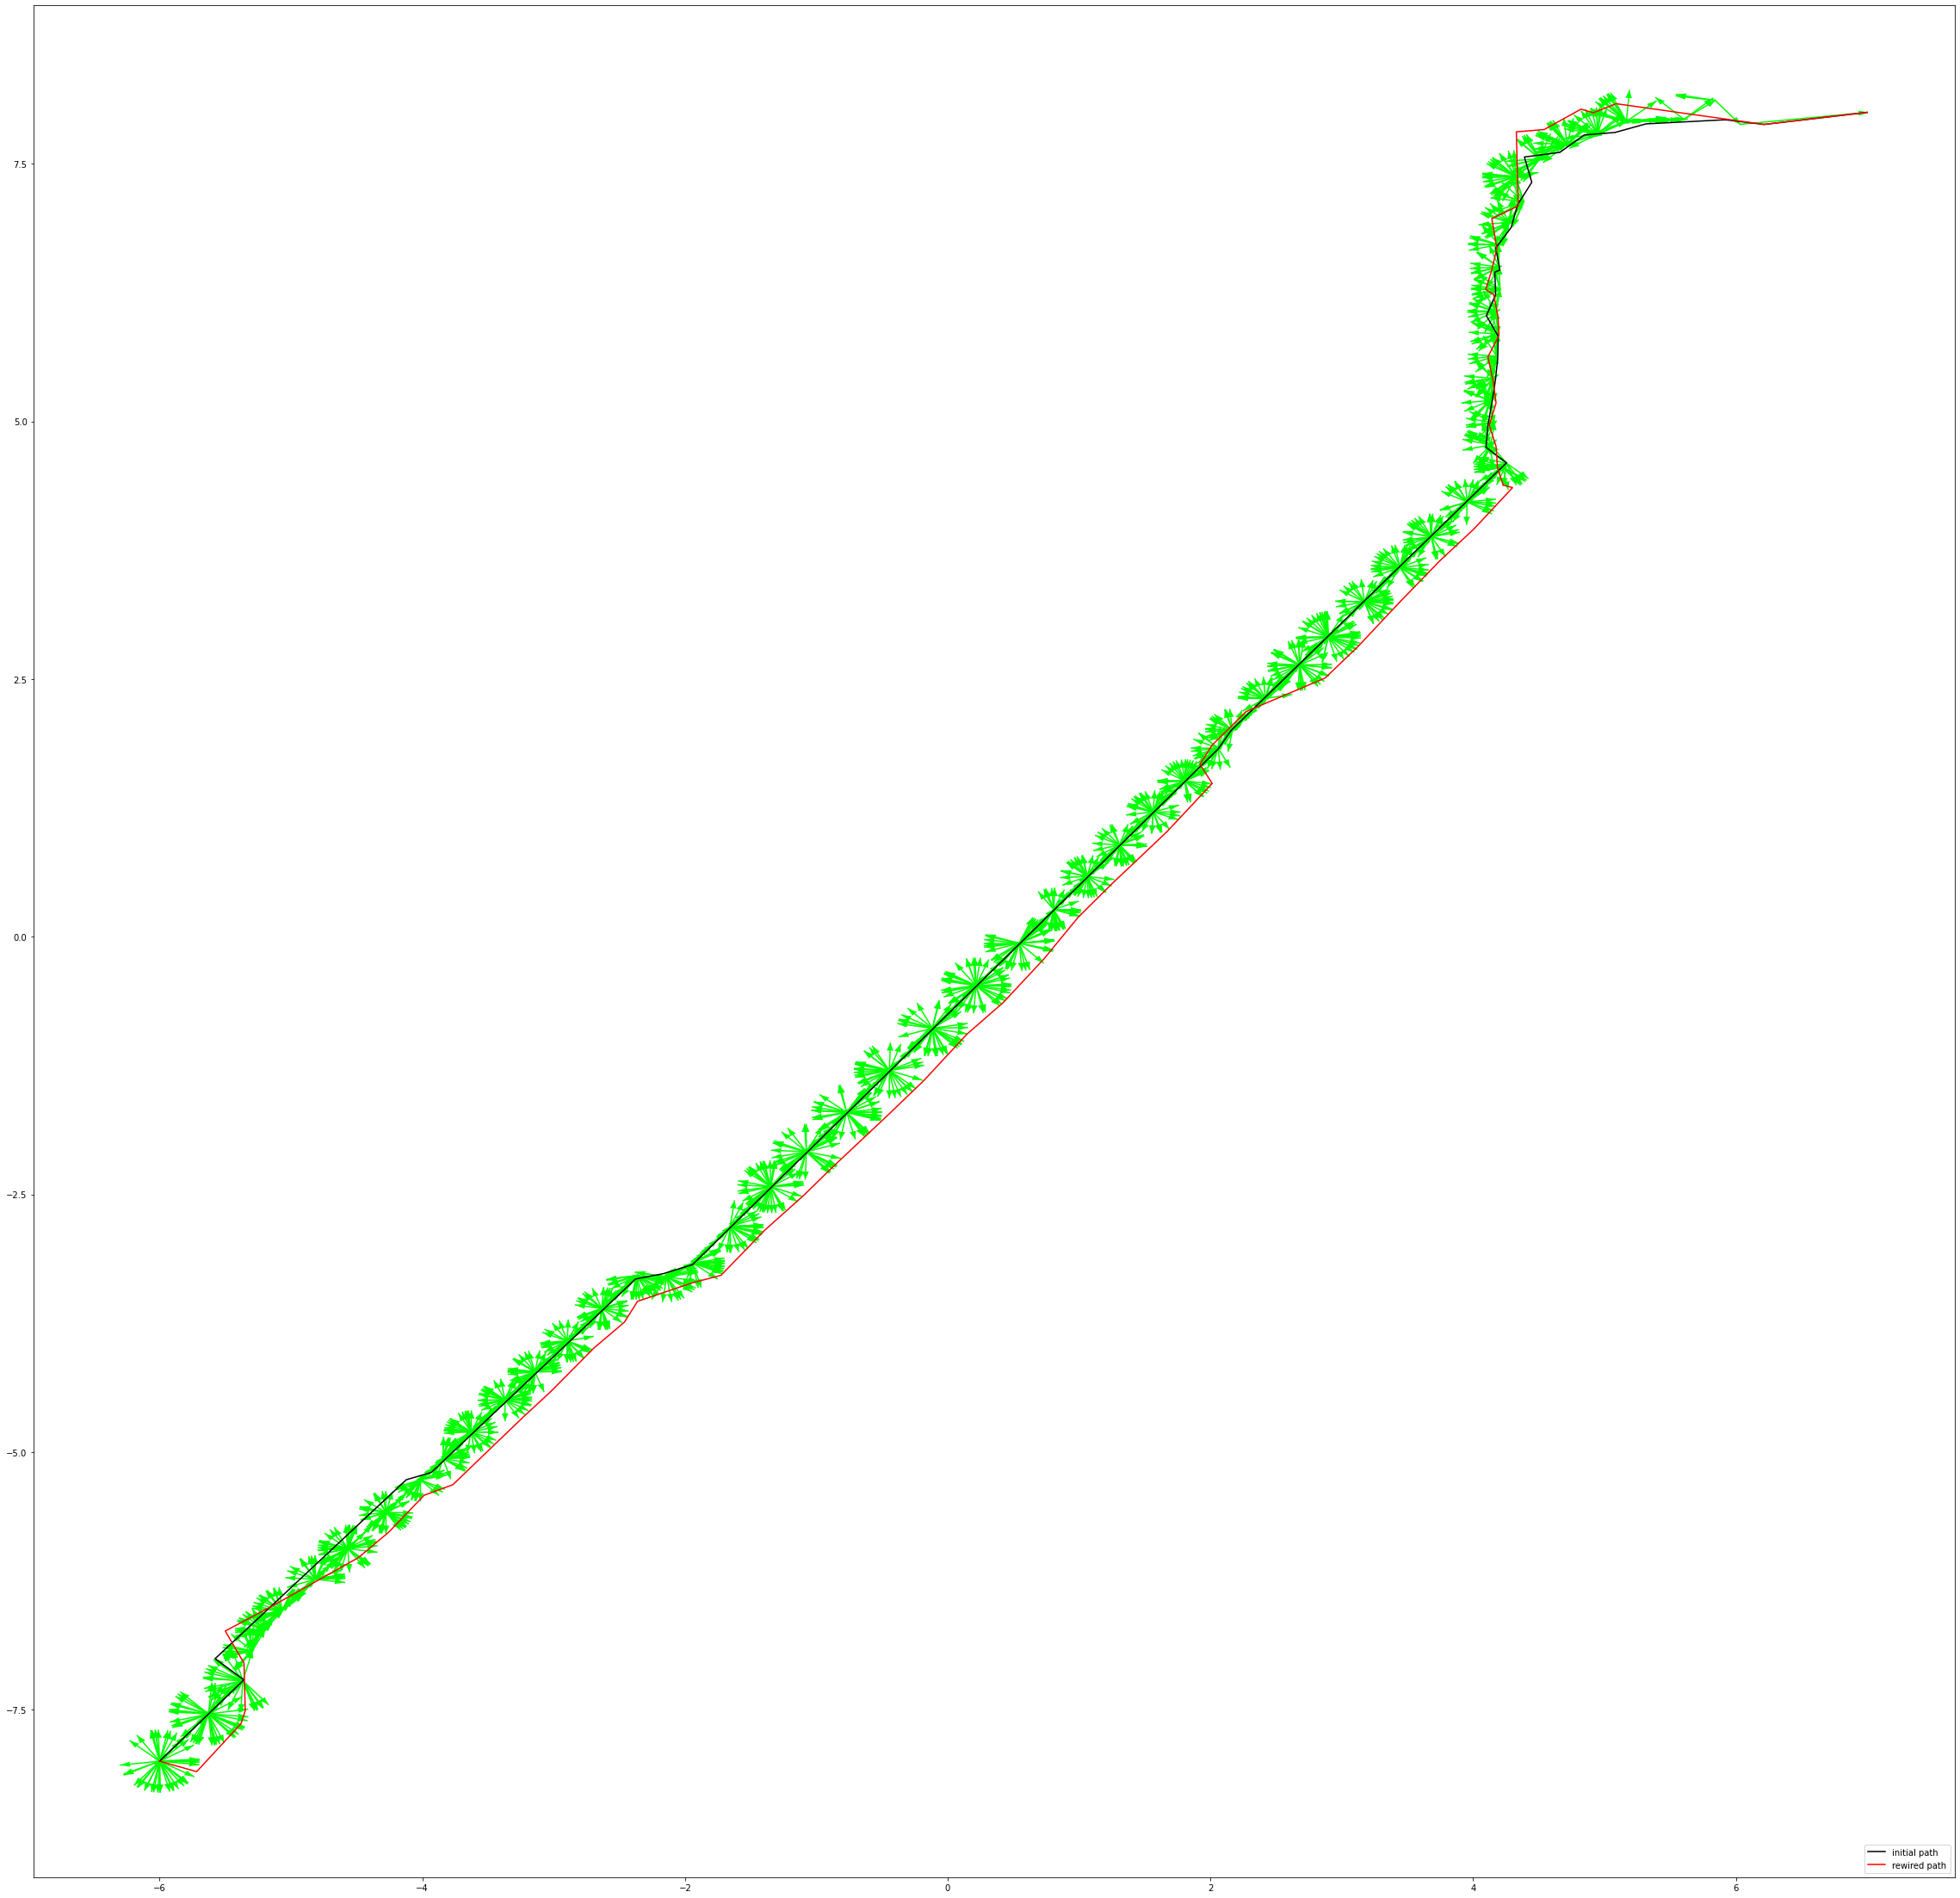

In [ ]:
plot_graph(G.edges(), path_lower,rewired_path_lower)

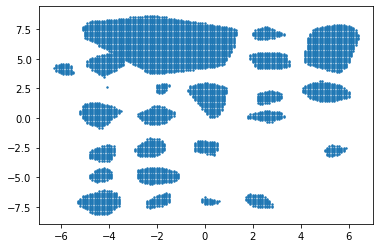

In [ ]:
plt.scatter([node.x for node in grids if node.value==0],[node.y for node in grids if node.value==0],s=2,cmap='Greens')


In [ ]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


fileId = '1fTgso1os7j0DYpymx9jAKRZpuSmCjq2H'      # simgle mango images

fileName = fileId + '.ply'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)



print('File Downloaded ' + fileName)

File Downloaded 1fTgso1os7j0DYpymx9jAKRZpuSmCjq2H.ply


In [ ]:
def check_equal(arr):
  for i in range(len(arr)-1):
    if arr[i]==arr[i+1]:
      continue
    else:
      return False
      print("yes")

  return True

arr=[1,1,2,2,3,3,4,4]
if len(arr)==1 or check_equal(arr):
  print("all are equal")
else:
  print("all are not equal")
#print(arr.count(arr[0]))

all are not equal


In [ ]:
# importing library sympy
from sympy import symbols, Eq, solve

# defining symbols used in equations
# or unknown variables
x, y = symbols('x,y')
A=np.array([[1,2],[3,4],[5,6]])
B=np.array([[3],[4],[5]])
print("Array A is ",A)
print("Array B is ",B)
print("B's first element ",B[0][0])
# defining equations
hullv=[]
for row in range(A.shape[0]):
  print("row no is ",A[row+1])
for row in range((A.shape[0])-1):
  x_coeff=A[row][0]
  y_coeff=A[row][1]
  eq1 = Eq(((x_coeff*x)+(y_coeff*y)), B[row][0])
  print("Equation 1:")
  print(eq1)
  eq2 = Eq(((A[row+1][0]*x)+(A[row+1][1]*y)), B[row+1][0])
  print("Equation 2")
  print(eq2)

# solving the equation
print("Values of 2 unknown variable are as follows:")

solndict=solve((eq1, eq2), (x, y))
hullv.append((solndict[x],solndict[y]))
print(solndict)
print("hull is ",hullv)

Array A is  [[1 2]
 [3 4]
 [5 6]]
Array B is  [[3]
 [4]
 [5]]
B's first element  3
row no is  [3 4]
row no is  [5 6]


IndexError: ignored

In [ ]:
dic={}
dic['ao']=24
dic['a1']=36
dic['a5']=49
for key in dic.keys():
  for j in range(5):
    print(j)
    if j==1:
      break

  print(dic[key])

In [ ]:
arr=[1,2,3,4,5]
i=0
for index,item in enumerate(arr):
  if item==3:

    arr[index]=8

print(arr)

In [ ]:
# ari=[(3,4),(4,5),(7,8)]
# k=(3,4)
# if k in ari:
#   ari[2]=k
#   print("yes")
# print(ari)

# p1=Node(3,4)
# p2=Node(5,6)
# p3=Node(7,8)
# paath=[]
# paath.append(p1)
# paath.append(p2)
# paath.append(p3)
# print("the original path is ",paath)
# paath[1]=p3
# print("the modified path is ",paath)
j=1
if -1<=j<=2:
  print(j)